# Machine Learning Evaluation Strategies


## 1. Introduction to Classification Evaluation <a id="introduction"></a>

When building a classification model, we need systematic ways to determine how well it performs. Classification problems come in many forms:

- Binary classification (two classes, like spam vs. not spam)
- Multi-class classification (multiple distinct classes)
- Multi-label classification (each instance can belong to multiple classes)

In this tutorial, we'll focus primarily on binary classification metrics, as they form the foundation for understanding more complex evaluation scenarios.

The ideal evaluation approach depends on several factors:
- The class distribution in your data (balanced vs. imbalanced)
- The relative cost of different types of errors
- Whether you need probabilities or just class labels
- The specific goals of your application

Let's begin by exploring how to set up our environment and create data to illustrate these concepts.

## 1.1 Setting Up Our Environment <a id="setup"></a>

First, we'll import the necessary libraries for our tutorial:

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve, 
    roc_auc_score,
    precision_recall_curve, 
    average_precision_score,
)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1.2 Creating Sample Data <a id="sample-data"></a>

To illustrate classification metrics, we'll create two datasets:
1. A balanced dataset where both classes appear with equal frequency
2. An imbalanced dataset where one class is much rarer than the other

This approach will help us understand how different metrics behave under various class distributions.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Create a balanced dataset
X_balanced, y_balanced = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.5, 0.5],  # Equal class probabilities
    random_state=42
)

# Create an imbalanced dataset (10% minority class)
X_imbalanced, y_imbalanced = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=2,
    weights=[0.9, 0.1],  # Imbalanced class probabilities
    random_state=42
)

# Split datasets into training and testing sets
X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(
    X_balanced, y_balanced, test_size=0.25, random_state=42
)

X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(
    X_imbalanced, y_imbalanced, test_size=0.25, random_state=42
)

# Check class distributions
print("Balanced dataset class distribution:")
print(pd.Series(y_balanced).value_counts(normalize=True))
print("\nImbalanced dataset class distribution:")
print(pd.Series(y_imbalanced).value_counts(normalize=True))

Balanced dataset class distribution:
0    0.5005
1    0.4995
Name: proportion, dtype: float64

Imbalanced dataset class distribution:
0    0.8966
1    0.1034
Name: proportion, dtype: float64


Now, let's train simple models on both datasets to use for our metrics exploration:

In [3]:
# Train a logistic regression model on the balanced dataset
lr_balanced = LogisticRegression(random_state=42)
lr_balanced.fit(X_bal_train, y_bal_train)

# Train a logistic regression model on the imbalanced dataset
lr_imbalanced = LogisticRegression(random_state=42)
lr_imbalanced.fit(X_imb_train, y_imb_train)

# Generate predictions and probability scores
y_bal_pred = lr_balanced.predict(X_bal_test)
y_bal_prob = lr_balanced.predict_proba(X_bal_test)[:, 1]

y_imb_pred = lr_imbalanced.predict(X_imb_test)
y_imb_prob = lr_imbalanced.predict_proba(X_imb_test)[:, 1]

# Train a second model (Random Forest) for comparison
rf_balanced = RandomForestClassifier(random_state=42)
rf_balanced.fit(X_bal_train, y_bal_train)
y_bal_pred_rf = rf_balanced.predict(X_bal_test)
y_bal_prob_rf = rf_balanced.predict_proba(X_bal_test)[:, 1]

rf_imbalanced = RandomForestClassifier(random_state=42)
rf_imbalanced.fit(X_imb_train, y_imb_train)
y_imb_pred_rf = rf_imbalanced.predict(X_imb_test)
y_imb_prob_rf = rf_imbalanced.predict_proba(X_imb_test)[:, 1]

## 1.3 Basic Classification Metrics <a id="basic-metrics"></a>

The foundation of classification evaluation is understanding the four possible outcomes of a binary classifier:

- **True Positives (TP)**: Correctly predicted positive cases
- **False Positives (FP)**: Incorrectly predicted positive cases (Type I error)
- **True Negatives (TN)**: Correctly predicted negative cases
- **False Negatives (FN)**: Incorrectly predicted negative cases (Type II error)

These four values form the basis for nearly all classification metrics we'll discuss.

### Confusion Matrix <a id="confusion-matrix"></a>

A confusion matrix visualizes the four possible outcomes in a 2×2 grid. It's the foundation for understanding classification performance.

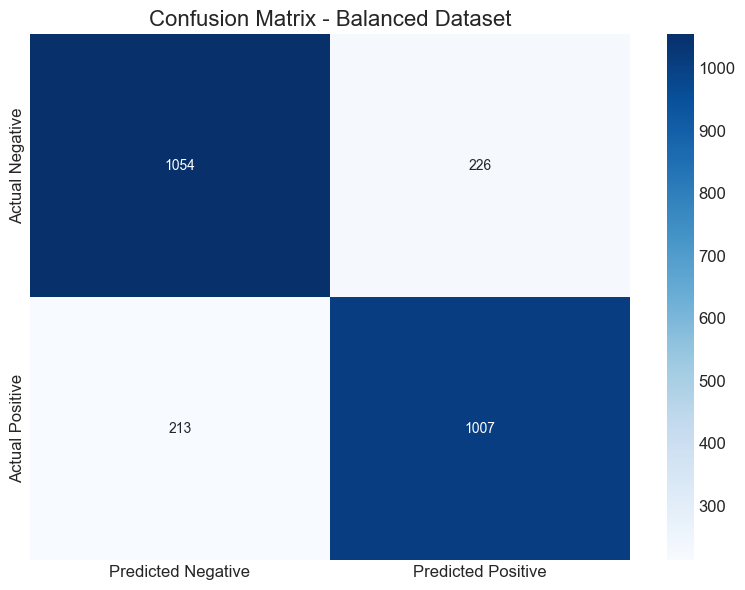

True Positives (TP): 1007
False Positives (FP): 226
True Negatives (TN): 1054
False Negatives (FN): 213


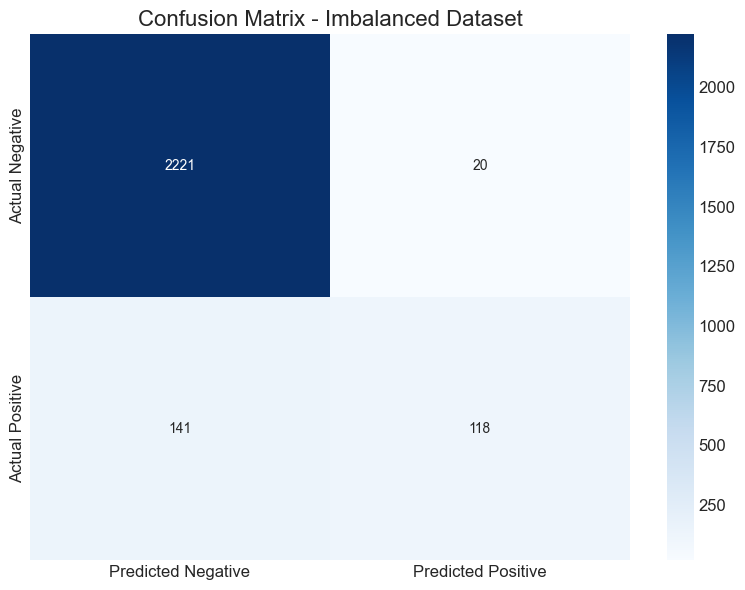

True Positives (TP): 118
False Positives (FP): 20
True Negatives (TN): 2221
False Negatives (FN): 141


In [4]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract values for annotation
    tn, fp, fn, tp = cm.ravel()
    
    # Create a heatmap visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print TP, FP, TN, FN values
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")

# Plot confusion matrices for both datasets
plot_confusion_matrix(y_bal_test, y_bal_pred, "Confusion Matrix - Balanced Dataset")
plot_confusion_matrix(y_imb_test, y_imb_pred, "Confusion Matrix - Imbalanced Dataset")

### Accuracy <a id="accuracy"></a>

Accuracy measures the proportion of correct predictions among the total number of predictions. While intuitive, it can be misleading for imbalanced datasets.

In [5]:
# Calculate accuracy for both datasets
balanced_accuracy = accuracy_score(y_bal_test, y_bal_pred)
imbalanced_accuracy = accuracy_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset accuracy: {balanced_accuracy:.4f}")
print(f"Imbalanced dataset accuracy: {imbalanced_accuracy:.4f}")

# Let's see what happens if we always predict the majority class in the imbalanced dataset
majority_predictions = np.zeros_like(y_imb_test)  # Assuming 0 is the majority class
minority_predictions = np.ones_like(y_imb_test)  # Assuming 0 is the majority class

majority_accuracy = accuracy_score(y_imb_test, majority_predictions)
minority_accuracy = accuracy_score(y_imb_test, minority_predictions)

print(f"Imbalanced dataset - majority class baseline accuracy: {majority_accuracy:.4f}")
print(f"Imbalanced dataset - minority class baseline accuracy: {minority_accuracy:.4f}")

Balanced dataset accuracy: 0.8244
Imbalanced dataset accuracy: 0.9356
Imbalanced dataset - majority class baseline accuracy: 0.8964
Imbalanced dataset - minority class baseline accuracy: 0.1036


As we can see, accuracy can be misleading with imbalanced data since a model that always predicts the majority class will still achieve seemingly high accuracy. This shows why we need more nuanced metrics for imbalanced classification problems.

### Precision <a id="precision"></a>

Precision measures how many of the predicted positive instances are actually positive. It's crucial when the cost of false positives is high.

$$\text{Precision} = \frac{TP}{TP + FP}$$

In [6]:
# Calculate precision for both datasets
balanced_precision = precision_score(y_bal_test, y_bal_pred)
imbalanced_precision = precision_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset precision: {balanced_precision:.4f}")
print(f"Imbalanced dataset precision: {imbalanced_precision:.4f}")

Balanced dataset precision: 0.8167
Imbalanced dataset precision: 0.8551


### Recall <a id="recall"></a>

Recall (also called sensitivity) measures how many of the actual positive instances our model correctly identified. It's important when missing positive cases is costly.

$$\text{Recall} = \frac{TP}{TP + FN}$$

In [7]:
# Calculate recall for both datasets
balanced_recall = recall_score(y_bal_test, y_bal_pred)
imbalanced_recall = recall_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset recall: {balanced_recall:.4f}")
print(f"Imbalanced dataset recall: {imbalanced_recall:.4f}")

Balanced dataset recall: 0.8254
Imbalanced dataset recall: 0.4556


### F1 Score <a id="f1-score"></a>

The F1 score is the harmonic mean of precision and recall, providing a balance between them. It's especially useful for imbalanced datasets.

$$F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [8]:
# Calculate F1 score for both datasets
balanced_f1 = f1_score(y_bal_test, y_bal_pred)
imbalanced_f1 = f1_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset F1 score: {balanced_f1:.4f}")
print(f"Imbalanced dataset F1 score: {imbalanced_f1:.4f}")

Balanced dataset F1 score: 0.8210
Imbalanced dataset F1 score: 0.5945


### Specificity <a id="specificity"></a>

Specificity measures how well the model identifies negative cases. It's the complement of the false positive rate.

$$\text{Specificity} = \frac{TN}{TN + FP}$$

In [9]:
# Calculate specificity manually (not directly available in sklearn)
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

balanced_specificity = specificity_score(y_bal_test, y_bal_pred)
imbalanced_specificity = specificity_score(y_imb_test, y_imb_pred)

print(f"Balanced dataset specificity: {balanced_specificity:.4f}")
print(f"Imbalanced dataset specificity: {imbalanced_specificity:.4f}")

Balanced dataset specificity: 0.8234
Imbalanced dataset specificity: 0.9911


## Multiclass Classification Evaluation Metrics

### Accuracy
Accuracy measures the proportion of correctly classified instances among all instances. While simple to understand, it can be misleading when classes are imbalanced.

```
Accuracy = Number of correct predictions / Total number of predictions
```

### Confusion Matrix
A tabular visualization showing predicted classes versus actual classes. For multiclass problems, this becomes an N×N matrix where N is the number of classes.

### Precision, Recall, and F1-Score
These metrics can be calculated for each class separately:

- **Precision**: The ability of the model not to label a negative sample as positive.
  ```
  Precision for class i = TP_i / (TP_i + FP_i)
  ```

- **Recall**: The ability of the model to find all positive samples.
  ```
  Recall for class i = TP_i / (TP_i + FN_i)
  ```

- **F1-Score**: The harmonic mean of precision and recall.
  ```
  F1 for class i = 2 * (Precision_i * Recall_i) / (Precision_i + Recall_i)
  ```

### Macro-averaging and Micro-averaging
For multiclass settings, we need ways to aggregate metrics across classes:

- **Macro-averaging**: Calculate the metric independently for each class and then take the average. This treats all classes equally.
  ```
  Macro-Precision = (Precision_1 + Precision_2 + ... + Precision_N) / N
  ```

- **Micro-averaging**: Aggregate the contributions of all classes to compute the average metric. This accounts for class imbalance.
  ```
  Micro-Precision = Total TP / (Total TP + Total FP)
  ```

- **Weighted-averaging**: Similar to macro-averaging but weighted by the number of true instances for each class.

### ROC Curves and AUC
For multiclass problems, ROC curves can be generated in a one-vs-rest manner (one curve per class). The AUC (Area Under the Curve) summarizes the model's ability to discriminate between classes.


### Multilabel Classification Evaluation Metrics

### Subset Accuracy (Exact Match Ratio)
A strict metric that requires the predicted set of labels to exactly match the true set of labels.
```
Subset Accuracy = Number of samples with all labels correctly predicted / Total number of samples
```

### Hamming Loss
The fraction of labels that are incorrectly predicted (smaller values are better).
```
Hamming Loss = (1/N) * Σ(1/L) * |y_i ⊕ h(x_i)|
```
where ⊕ represents the XOR operation, N is the number of samples, and L is the number of labels.

### Jaccard Index (Jaccard Similarity Coefficient)
Measures the similarity between the predicted and true label sets.
```
Jaccard Index = |Y ∩ Ŷ| / |Y ∪ Ŷ|
```
where Y is the true label set and Ŷ is the predicted label set.

### Precision, Recall, and F1-Score for Multilabel
These can be calculated in several ways:

- **Sample-averaged**: Calculate metrics for each instance and then average.
- **Micro-averaged**: Calculate metrics globally by counting the total true positives, false negatives, and false positives.
- **Macro-averaged**: Calculate metrics for each label and then average.

### Label Ranking Metrics
When the model outputs probabilities for each label:

- **Coverage error**: How far on average we need to go down the ranked list of labels to cover all true labels.
- **Ranking loss**: The average number of label pairs that are incorrectly ordered.
- **Average precision**: The average precision at the positions of all true labels.



## Choosing the Right Metric

The choice of evaluation metric depends on your specific problem:

- Use **accuracy** when classes are balanced and misclassification costs are similar.
- Use **macro-averaging** when you care equally about all classes regardless of their frequency.
- Use **micro-averaging** when you care more about frequent classes.
- For multilabel problems, consider the **Jaccard index** for an overall similarity measure.
- Use **Hamming loss** when partial correctness is valuable in multilabel settings.

## 1.4 Threshold-Based Evaluation <a id="threshold-evaluation"></a>

Most classification algorithms don't just predict classes; they output probability scores that are converted to class labels using a threshold (typically 0.5). By adjusting this threshold, we can trade off between different types of errors.

### ROC Curve and AUC <a id="roc-curve"></a>

The Receiver Operating Characteristic (ROC) curve plots the true positive rate (recall) against the false positive rate at various threshold settings. The Area Under the Curve (AUC) provides a single metric that measures the overall performance across all thresholds.

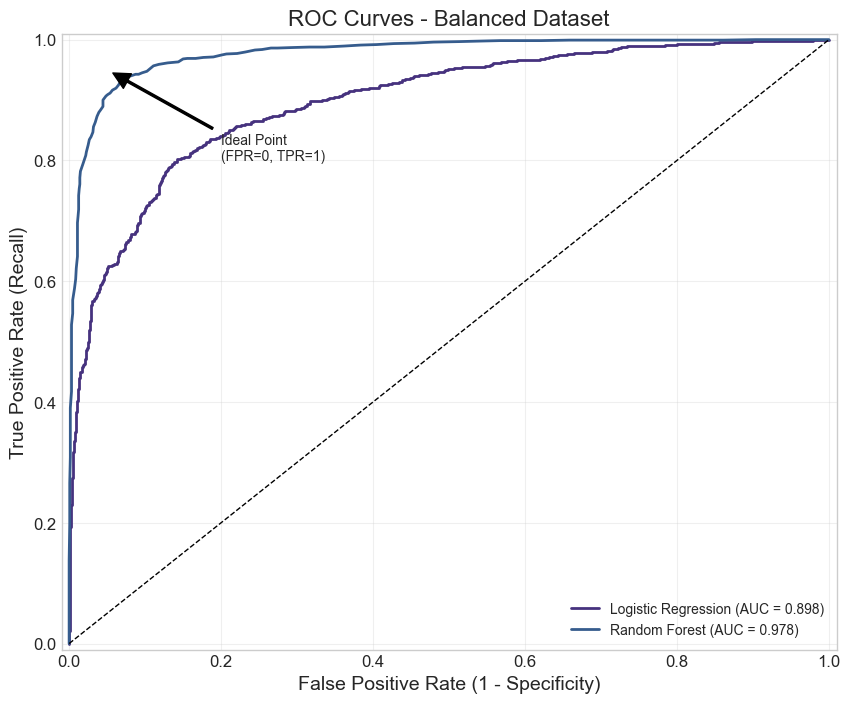

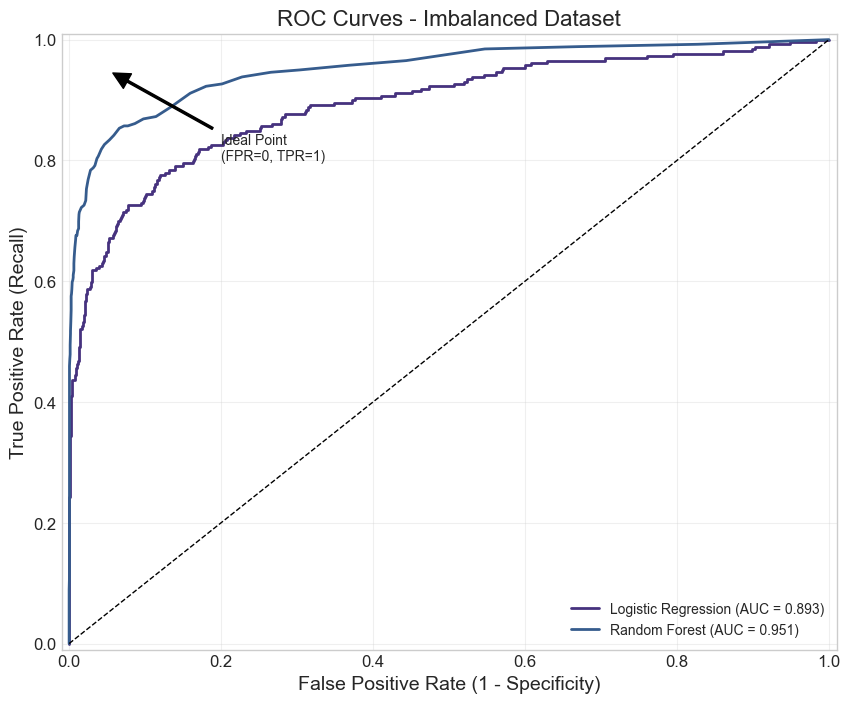

In [10]:
def plot_roc_curves(models_data, title):
    plt.figure(figsize=(10, 8))
    
    for label, data in models_data.items():
        y_true, y_prob = data
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, linewidth=2, label=f"{label} (AUC = {auc:.3f})")
    
    # Add diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    
    # Add labels and legend
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # Adjust axes
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    plt.annotate('Ideal Point\n(FPR=0, TPR=1)', xy=(0.05, 0.95), xytext=(0.2, 0.8), arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Compare logistic regression and random forest on both datasets
balanced_models = {
    'Logistic Regression': (y_bal_test, y_bal_prob),
    'Random Forest': (y_bal_test, y_bal_prob_rf)
}

imbalanced_models = {
    'Logistic Regression': (y_imb_test, y_imb_prob),
    'Random Forest': (y_imb_test, y_imb_prob_rf)
}

plot_roc_curves(balanced_models, "ROC Curves - Balanced Dataset")
plot_roc_curves(imbalanced_models, "ROC Curves - Imbalanced Dataset")

### Precision-Recall Curve <a id="pr-curve"></a>

The Precision-Recall (PR) curve plots precision versus recall at different threshold settings. It's particularly useful for imbalanced datasets where the ROC curve might be overly optimistic.

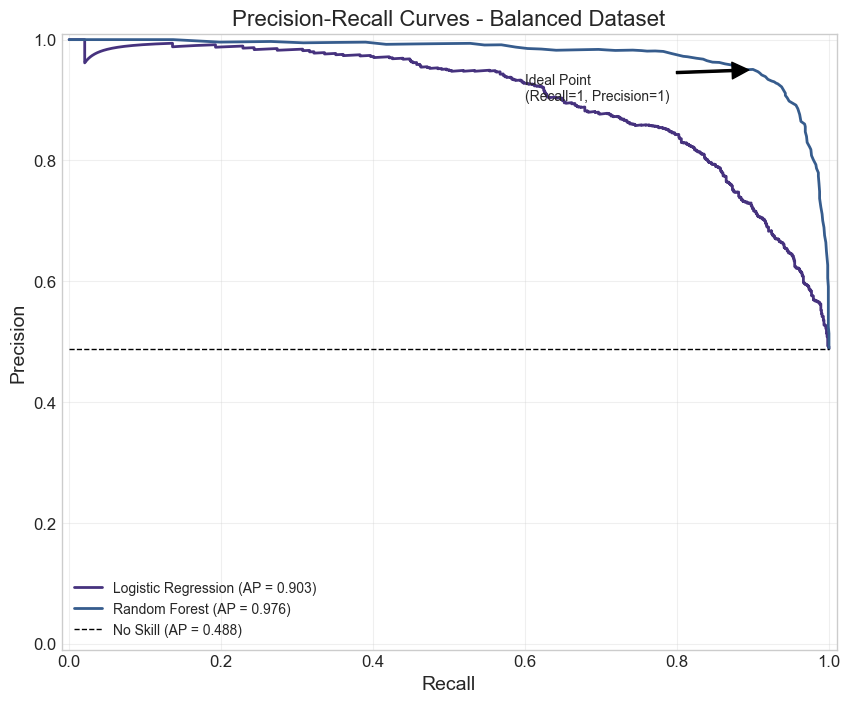

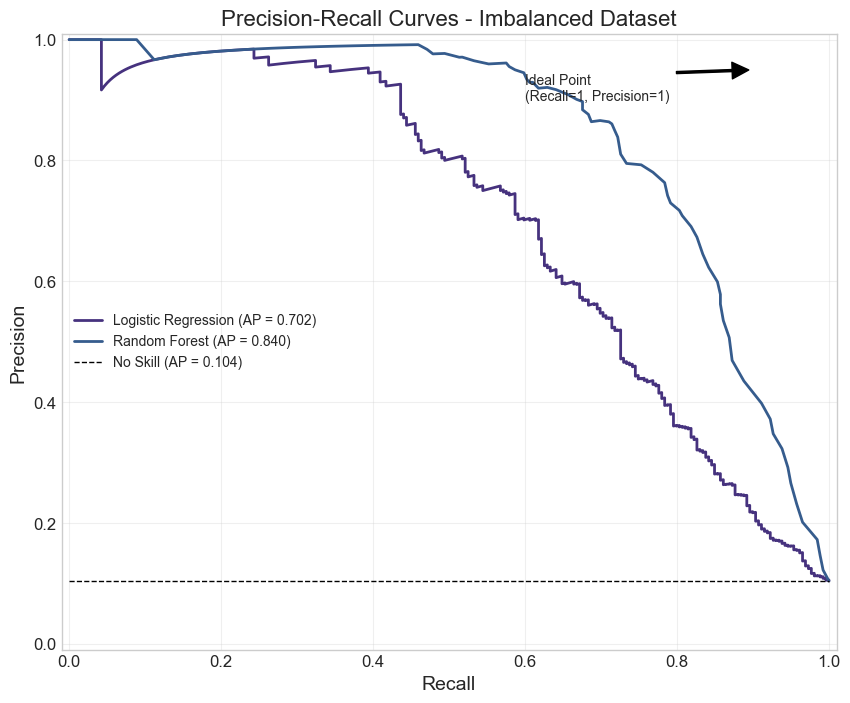

In [11]:
def plot_pr_curves(models_data, title):
    plt.figure(figsize=(10, 8))
    
    for label, data in models_data.items():
        y_true, y_prob = data
        
        # Calculate PR curve
        precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        
        # Plot PR curve
        plt.plot(recall, precision, linewidth=2, label=f"{label} (AP = {ap:.3f})")
    
    # Add baseline (no-skill classifier)
    no_skill = sum(y_true) / len(y_true)  # Frequency of positive class
    plt.plot([0, 1], [no_skill, no_skill], 'k--', linewidth=1, label=f'No Skill (AP = {no_skill:.3f})')
    
    # Add labels and legend
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    # Adjust axes
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    plt.annotate('Ideal Point\n(Recall=1, Precision=1)', xy=(0.9, 0.95), xytext=(0.6, 0.9),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Plot PR curves for both datasets
plot_pr_curves(balanced_models, "Precision-Recall Curves - Balanced Dataset")
plot_pr_curves(imbalanced_models, "Precision-Recall Curves - Imbalanced Dataset")

## 1.5 Tradeoffs in Classification Evaluation <a id="tradeoffs"></a>

Let's dive deeper into the tradeoffs between different performance metrics and specifically focus on when to use ROC versus PR curves.

In [12]:
def analyze_thresholds(y_true, y_prob, thresholds, model_name, dataset_name, num_points=10):
    # Select a subset of thresholds to analyze
    indices = np.linspace(0, len(thresholds) - 1, num_points, dtype=int)
    selected_thresholds = thresholds[indices]
    
    # Calculate metrics for each threshold
    results = []
    for threshold in selected_thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall/Sensitivity
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = 2 * precision * tpr / (precision + tpr) if (precision + tpr) > 0 else 0
        
        results.append({
            'Threshold': threshold,
            'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
            'Precision': precision,
            'Recall (TPR)': tpr,
            'Specificity (TNR)': tnr,
            'FPR': fpr,
            'F1 Score': f1
        })
    
    # Convert to DataFrame for better display
    results_df = pd.DataFrame(results)
    print(f"Threshold analysis for {model_name} on {dataset_name}:")
    return results_df

# Analyze thresholds for Logistic Regression on imbalanced dataset
precision, recall, thresholds = precision_recall_curve(imbalanced_models['Logistic Regression'][0], imbalanced_models['Logistic Regression'][1])

log_reg_imb_thresholds = analyze_thresholds(
    y_imb_test, 
    imbalanced_models['Logistic Regression'][1],
    thresholds,
    'Logistic Regression',
    'Imbalanced Dataset'
)

# Display the results
pd.set_option('display.precision', 3)
display(log_reg_imb_thresholds[['Threshold', 'Precision', 'Recall (TPR)', 'Specificity (TNR)', 'F1 Score']])

Threshold analysis for Logistic Regression on Imbalanced Dataset:


,Threshold,Precision,Recall (TPR),Specificity (TNR),F1 Score
0,2.186e-04,0.104,1.000,0.000,0.188
1,4.931e-03,0.114,0.981,0.121,0.205
2,9.824e-03,0.129,0.969,0.244,0.228
3,1.660e-02,0.150,0.965,0.368,0.260
4,2.563e-02,0.173,0.927,0.487,0.291
5,3.899e-02,0.210,0.903,0.608,0.341
6,6.171e-02,0.267,0.861,0.727,0.408
7,1.103e-01,0.370,0.795,0.843,0.505
8,2.413e-01,0.602,0.649,0.950,0.625
9,9.991e-01,1.000,0.004,1.000,0.008


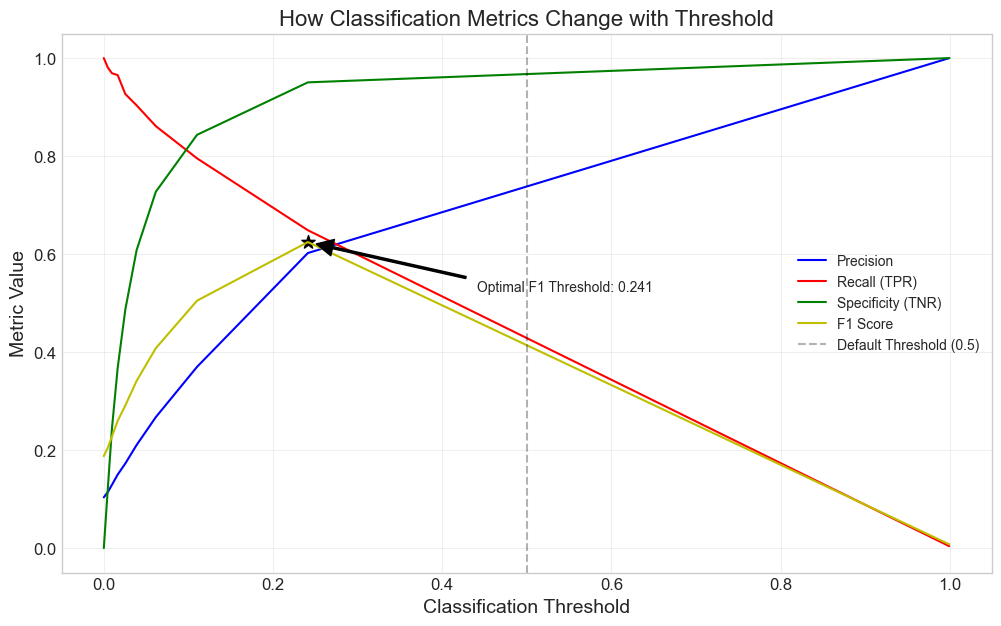

In [13]:
def plot_threshold_tradeoffs(threshold_df):
    plt.figure(figsize=(12, 7))
    
    plt.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-', label='Precision')
    plt.plot(threshold_df['Threshold'], threshold_df['Recall (TPR)'], 'r-', label='Recall (TPR)')
    plt.plot(threshold_df['Threshold'], threshold_df['Specificity (TNR)'], 'g-', label='Specificity (TNR)')
    plt.plot(threshold_df['Threshold'], threshold_df['F1 Score'], 'y-', label='F1 Score')
    
    plt.axvline(x=0.5, color='k', linestyle='--', alpha=0.3, label='Default Threshold (0.5)')
    
    plt.xlabel('Classification Threshold')
    plt.ylabel('Metric Value')
    plt.title('How Classification Metrics Change with Threshold')
    plt.legend(loc='center right')
    plt.grid(True, alpha=0.3)
    
    # Add annotation about the decision point
    f1_max_idx = threshold_df['F1 Score'].argmax()
    optimal_threshold = threshold_df.iloc[f1_max_idx]['Threshold']
    
    plt.scatter(optimal_threshold, threshold_df.iloc[f1_max_idx]['F1 Score'], 
                s=100, c='black', marker='*')
    plt.annotate(f'Optimal F1 Threshold: {optimal_threshold:.3f}', 
                 xy=(optimal_threshold, threshold_df.iloc[f1_max_idx]['F1 Score']),
                 xytext=(optimal_threshold+0.2, threshold_df.iloc[f1_max_idx]['F1 Score']-0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
    
    plt.show()

# Plot the threshold tradeoffs
plot_threshold_tradeoffs(log_reg_imb_thresholds)

### Key Insights on ROC Curves

1. **ROC Curve Interpretation**:
   - The diagonal line represents a random classifier (AUC = 0.5)
   - Curves closer to the top-left corner indicate better performance (AUC closer to 1.0)
   - The Area Under the Curve (AUC) provides a single number to compare models

2. **Threshold Selection Tradeoffs**:
   - Lower thresholds: Higher recall (TPR), but also higher false positives (FPR)
   - Higher thresholds: Lower false positives, but also lower recall
   - The 'best' threshold depends on the specific costs of false positives vs. false negatives in your application

3. **ROC Curves Limitations**:
   - They can be misleading for imbalanced datasets
   - They don't directly show precision, which is often important in imbalanced scenarios

In [14]:
# Summary of key classification metrics and when to use them

metrics_summary = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 
        'F1 Score', 'AUC-ROC', 'Average Precision (AP)', 'Balanced Accuracy'
    ],
    'Description': [
        'Proportion of correct predictions (TP+TN)/(TP+TN+FP+FN)',
        'Proportion of positive predictions that are correct TP/(TP+FP)',
        'Proportion of actual positives correctly identified TP/(TP+FN)',
        'Proportion of actual negatives correctly identified TN/(TN+FP)',
        'Harmonic mean of precision and recall 2*(P*R)/(P+R)',
        'Area under the ROC curve (TPR vs FPR)',
        'Area under the precision-recall curve',
        'Average of recall and specificity (TPR+TNR)/2'
    ],
    'When to Use': [
        'Balanced datasets, equal misclassification costs',
        'When false positives are costly (spam detection, content filtering)',
        'When false negatives are costly (disease detection, fraud monitoring)',
        'When correctly identifying negatives is important (medical screening)',
        'When balance between precision and recall is needed, imbalanced datasets',
        'Model comparison, balanced datasets, ranking performance',
        'Imbalanced datasets, focus on positive class performance',
        'Imbalanced datasets, when both classes are important'
    ]
})

pd.set_option('display.max_colwidth',100)  
display(metrics_summary)

,Metric,Description,When to Use
0,Accuracy,Proportion of correct predictions (TP+TN)/(TP+TN+FP+FN),"Balanced datasets, equal misclassification costs"
1,Precision,Proportion of positive predictions that are correct TP/(TP+FP),"When false positives are costly (spam detection, content filtering)"
2,Recall (Sensitivity),Proportion of actual positives correctly identified TP/(TP+FN),"When false negatives are costly (disease detection, fraud monitoring)"
3,Specificity,Proportion of actual negatives correctly identified TN/(TN+FP),When correctly identifying negatives is important (medical screening)
4,F1 Score,Harmonic mean of precision and recall 2*(P*R)/(P+R),"When balance between precision and recall is needed, imbalanced datasets"
5,AUC-ROC,Area under the ROC curve (TPR vs FPR),"Model comparison, balanced datasets, ranking performance"
6,Average Precision (AP),Area under the precision-recall curve,"Imbalanced datasets, focus on positive class performance"
7,Balanced Accuracy,Average of recall and specificity (TPR+TNR)/2,"Imbalanced datasets, when both classes are important"


## 1.6 Conclusion: Key Takeaways for Classification Metrics

1. **No Single Perfect Metric**: The choice of evaluation metric should align with your specific problem and business requirements. There's no one-size-fits-all approach.

2. **Understand Class Imbalance**: Class imbalance significantly affects which metrics are most informative. Accuracy can be misleading with imbalanced data.

3. **Consider the Cost of Errors**: Different types of errors (false positives vs. false negatives) often have different real-world costs. Your metrics should reflect these costs.

4. **ROC vs. PR Curves**:
   - ROC curves are better for balanced datasets and when both classes matter
   - PR curves are better for imbalanced datasets and when the positive class is more important

5. **Threshold Selection**: Choosing the right threshold involves understanding the tradeoffs between metrics and should be based on the specific requirements of your application.

6. **Beyond Binary Classification**: For multi-class problems, consider metrics like macro/micro/weighted averages of per-class metrics, confusion matrices, and Cohen's Kappa.

7. **Evaluate with Multiple Metrics**: Use a combination of metrics to get a comprehensive view of model performance rather than optimizing for a single metric.

8. **Context Matters**: Always interpret metrics in the context of your specific problem domain and baseline performance.

By understanding these evaluation metrics and their tradeoffs, you can make more informed decisions about model selection and threshold optimization for your specific use case.

## 1.7 Real World Scenario example: Fraud Detection

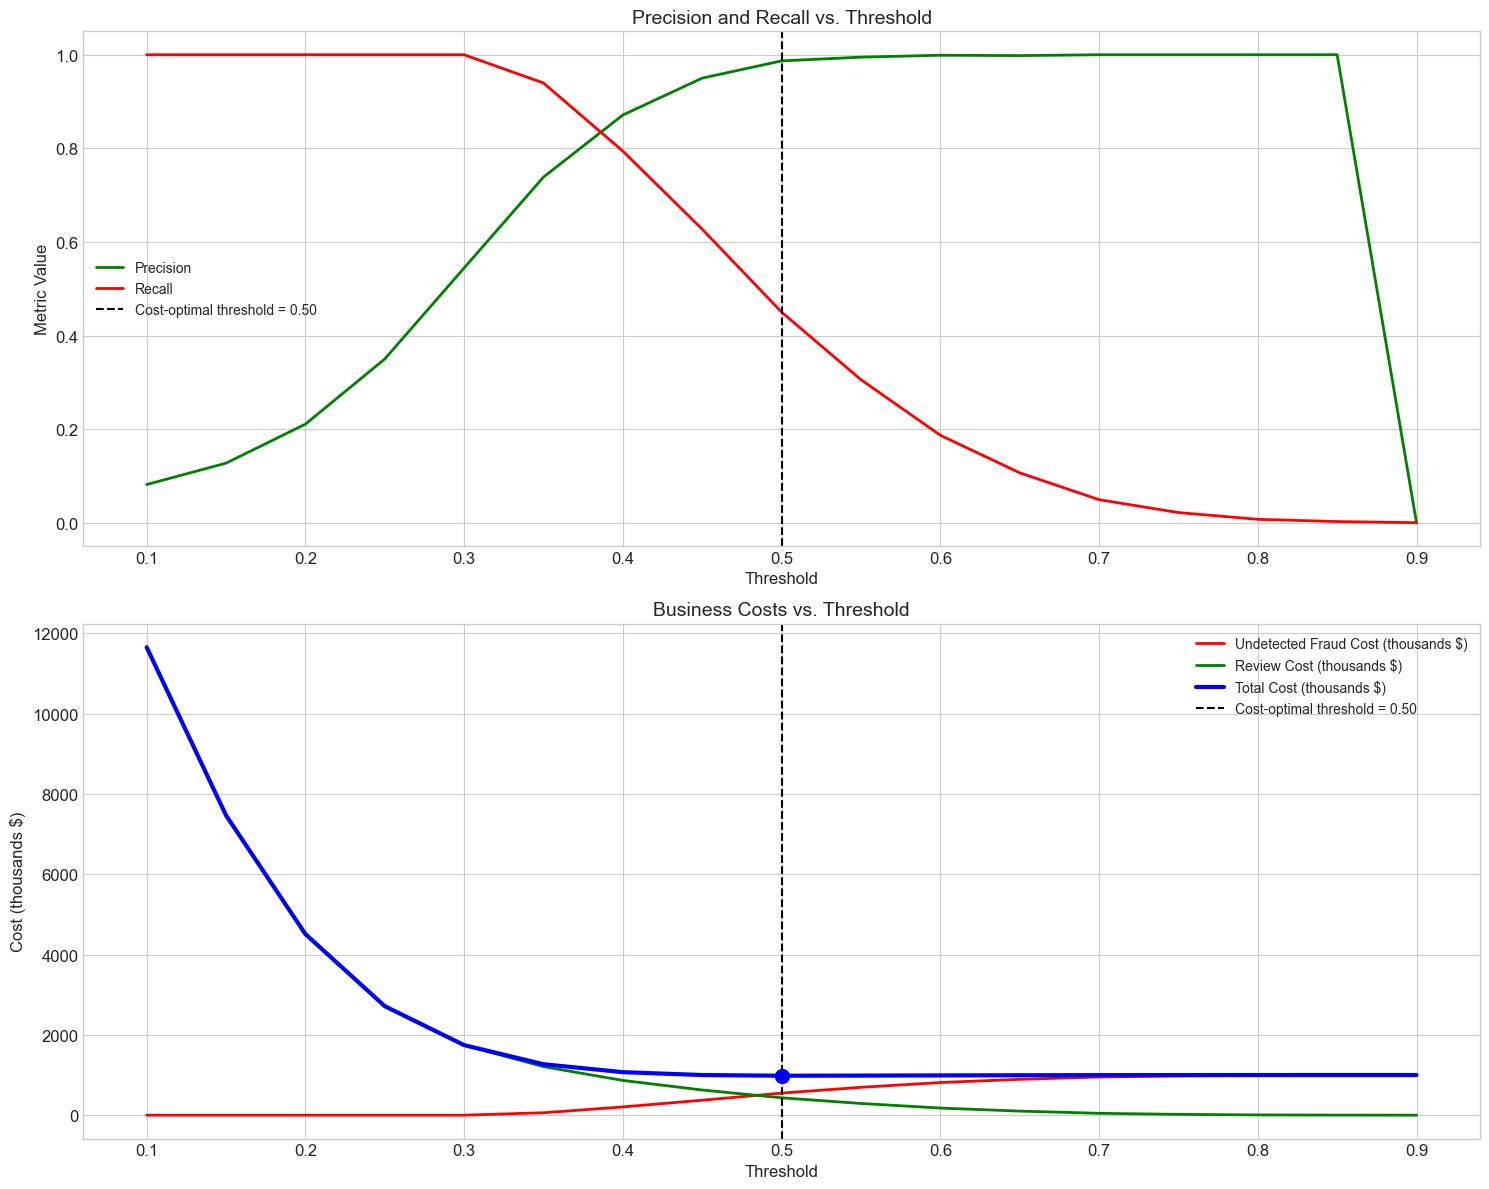


--- Business Impact Analysis ---
Optimal threshold for minimizing total cost: 0.500
+---------------------+-------------+----------+-------------------+-------------------+---------------+
| Threshold           |   Precision |   Recall |   False Positives |   False Negatives | Total Cost    |
+=====================+=============+==========+===================+===================+===============+
| Low (0.2)           |       0.211 |    1     |             18746 |                 0 | $4,511,740.00 |
+---------------------+-------------+----------+-------------------+-------------------+---------------+
| High (0.8)          |       1     |    0.007 |                 0 |              4964 | $999,640.00   |
+---------------------+-------------+----------+-------------------+-------------------+---------------+
| F1-optimal (0.40)   |       0.871 |    0.794 |               587 |              1030 | $1,071,830.00 |
+---------------------+-------------+----------+-------------------+-------

In [15]:

# Let's create a practical example of how threshold selection impacts a real-world scenario
def threshold_business_impact_simulation(avg_transaction,fraud_cost_multiple,review_cost):
    """
    Simulates a business case to show how threshold selection impacts outcomes.
    """
    # Let's simulate a fraud detection scenario
    np.random.seed(42)
    
    # Create synthetic data for a fraud detection case
    # Assume 5% of transactions are fraudulent
    n_samples = 100000
    n_fraud = int(n_samples * 0.05)
    n_legitimate = n_samples - n_fraud
    
    # Generate probabilities for fraudulent transactions (higher scores)
    fraud_probs = np.random.beta(2, 5, n_fraud)
    # Shift to make them higher probability
    fraud_probs = 0.3 + fraud_probs * 0.7
    
    # Generate probabilities for legitimate transactions (lower scores)
    legitimate_probs = np.random.beta(2, 10, n_legitimate)
    # Shift to make them lower probability
    legitimate_probs = legitimate_probs * 0.8
    
    # Combine data
    y_true = np.array([1] * n_fraud + [0] * n_legitimate)
    y_prob = np.concatenate([fraud_probs, legitimate_probs])
    
    # Shuffle data
    idx = np.random.permutation(len(y_true))
    y_true = y_true[idx]
    y_prob = y_prob[idx]
    
    # Define function to calculate business impact
    def calculate_impact(threshold):
        y_pred = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calculate costs
        undetected_fraud_cost = fn * avg_transaction * fraud_cost_multiple
        review_cost_total = (tp + fp) * review_cost
        total_cost = undetected_fraud_cost + review_cost_total
        
        # Calculate other metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        return {
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'false_positives': fp,
            'false_negatives': fn,
            'undetected_fraud_cost': undetected_fraud_cost,
            'review_cost': review_cost_total,
            'total_cost': total_cost
        }
    
    # Calculate impact for various thresholds
    thresholds = np.linspace(0.1, 0.9, 17)
    impacts = [calculate_impact(t) for t in thresholds]
    
    # Extract values for plotting
    precision_values = [imp['precision'] for imp in impacts]
    recall_values = [imp['recall'] for imp in impacts]
    undetected_fraud_costs = [imp['undetected_fraud_cost'] for imp in impacts]
    review_costs = [imp['review_cost'] for imp in impacts]
    total_costs = [imp['total_cost'] for imp in impacts]
    
    # Find optimal threshold for minimizing total cost
    best_idx = np.argmin(total_costs)
    best_threshold = thresholds[best_idx]
    
    # Plot business impact
    plt.figure(figsize=(15, 12))


    # Plot 1: Precision and Recall vs Threshold
    plt.subplot(2, 1, 1)
    plt.plot(thresholds, precision_values, 'g-', label='Precision', linewidth=2)
    plt.plot(thresholds, recall_values, 'r-', label='Recall', linewidth=2)
    plt.axvline(x=best_threshold, color='k', linestyle='--', 
                label=f'Cost-optimal threshold = {best_threshold:.2f}')
    
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.title('Precision and Recall vs. Threshold', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    
    # Plot 2: Costs vs Threshold
    plt.subplot(2, 1, 2)
    plt.plot(thresholds, np.array(undetected_fraud_costs)/1000, 'r-', 
             label='Undetected Fraud Cost (thousands $)', linewidth=2)
    plt.plot(thresholds, np.array(review_costs)/1000, 'g-', 
             label='Review Cost (thousands $)', linewidth=2)
    plt.plot(thresholds, np.array(total_costs)/1000, 'b-', 
             label='Total Cost (thousands $)', linewidth=3)
    plt.axvline(x=best_threshold, color='k', linestyle='--', 
                label=f'Cost-optimal threshold = {best_threshold:.2f}')
    
    # Highlight minimum cost point
    plt.scatter(best_threshold, total_costs[best_idx]/1000, color='blue', s=100, zorder=5)
    
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Cost (thousands $)', fontsize=12)
    plt.title('Business Costs vs. Threshold', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


    # Print analysis of different thresholds
    print("\n--- Business Impact Analysis ---")
    print(f"Optimal threshold for minimizing total cost: {best_threshold:.3f}")
    
    # Compare with metrics-based thresholds
    best_f1_idx = np.argmax([2 * (p * r) / (p + r) if (p + r) > 0 else 0 
                           for p, r in zip(precision_values, recall_values)])
    best_f1_threshold = thresholds[best_f1_idx]
    
    low_threshold = 0.2
    high_threshold = 0.8
    
    # Get results for different thresholds
    low_result = calculate_impact(low_threshold)
    high_result = calculate_impact(high_threshold)
    f1_result = calculate_impact(best_f1_threshold)
    optimal_result = impacts[best_idx]
    
    # Create comparison table
    from tabulate import tabulate
    
    table_data = [
        ["Low (0.2)", f"{low_result['precision']:.3f}", f"{low_result['recall']:.3f}", 
         f"{low_result['false_positives']}", f"{low_result['false_negatives']}", 
         f"${low_result['total_cost']:,.2f}"],
        ["High (0.8)", f"{high_result['precision']:.3f}", f"{high_result['recall']:.3f}", 
         f"{high_result['false_positives']}", f"{high_result['false_negatives']}", 
         f"${high_result['total_cost']:,.2f}"],
        [f"F1-optimal ({best_f1_threshold:.2f})", f"{f1_result['precision']:.3f}", 
         f"{f1_result['recall']:.3f}", f"{f1_result['false_positives']}", 
         f"{f1_result['false_negatives']}", f"${f1_result['total_cost']:,.2f}"],
        [f"Cost-optimal ({best_threshold:.2f})", f"{optimal_result['precision']:.3f}", 
         f"{optimal_result['recall']:.3f}", f"{optimal_result['false_positives']}", 
         f"{optimal_result['false_negatives']}", f"${optimal_result['total_cost']:,.2f}"]
    ]
    
    headers = ["Threshold", "Precision", "Recall", "False Positives", "False Negatives", "Total Cost"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    print("\nKey insights:")
    print("1. The cost-optimal threshold balances the costs of manual reviews and undetected fraud")
    print("2. Using a technical metric like F1 score may not lead to the optimal business outcome")
    print(f"3. In this scenario, the cost-optimal threshold ({best_threshold:.2f}) differs from the F1-optimal threshold ({best_f1_threshold:.2f})")
    print("4. Low thresholds lead to higher recall but more false positives (higher review costs)")
    print("5. High thresholds lead to higher precision but more false negatives (higher fraud costs)")
    print("6. The optimal threshold depends on the specific business costs and should be adjusted as these costs change")



# Business impact parameters (fictional values)

avg_transaction = 200  # Average transaction amount: $100
fraud_cost_multiple = 1  # Cost of undetected fraud is 2.5x the transaction amount
review_cost = 190  # Cost to manually review a transaction: $120

threshold_business_impact_simulation(avg_transaction,fraud_cost_multiple,review_cost)

## BREAK

## 2. Regression Metrics Evaluation


## 2.1 Setting Up Our Environment <a id="setup"></a>

First, we'll import the necessary libraries for our tutorial:

In [16]:
# Core libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Metrics for regression evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# For displaying visualizations inline
%matplotlib inline

# Set a random seed for reproducibility
np.random.seed(42)

# Set a nice style for our plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 2.2 Creating Sample Data <a id="sample-data"></a>


In [17]:
# Generate a synthetic regression dataset
X, y = make_regression(n_samples=10000, n_features=20, n_informative=10, 
                        noise=20, random_state=42)

# Split the data into training, validation, and test sets
# First split: 80% train+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 75% train, 25% validation (from the train+validation set)
# This gives us an overall 60% train, 20% validation, 20% test split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 6000 samples
Validation set: 2000 samples
Test set: 2000 samples


In [18]:
# Train a simple Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train a Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Define a dictionary to store our models
models = {
    'Linear Regression': linear_model,
    'Random Forest': rf_model,
    'Decision Tree': dt_model
}

## 2.3 Basic Regression Metrics


### Understanding Regression Metrics

Let's dive deeper into what each of these metrics tells us:

1. **Mean Squared Error (MSE)**: 
   - Calculates the average of squared differences between predictions and actual values
   - Heavily penalizes large errors due to squaring
   - Lower values are better, with 0 being a perfect score
   - Formula: $MSE = (1/n) * Σ$ (y_actual - y_predicted)²

2. **Root Mean Squared Error (RMSE)**:
   - Square root of MSE
   - Has the same units as the target variable, making it more interpretable
   - Still sensitive to outliers
   - Lower values are better
   - Formula: $RMSE = √MSE$

3. **Mean Absolute Error (MAE)**:
   - Average of absolute differences between predictions and actual values
   - Less sensitive to outliers than MSE/RMSE
   - In the same unit as the target variable
   - Lower values are better
   - Formula: $MAE = (1/n) * Σ$ |y_actual - y_predicted|

4. **R² Score (Coefficient of Determination)**:
   - Represents the proportion of variance in the target that is predictable from the features
   - Ranges typically from 0 to 1 (1 being perfect prediction)
   - Can be negative if the model is worse than a horizontal line
   - Formula: $R² = 1 - $(Sum of squared residuals / Total sum of squares)

5. **Mean Absolute Percentage Error (MAPE)**:
   - Average of absolute percentage errors
   - Scale-independent, allowing comparison across different datasets
   - Can be misleading when actual values are close to zero
   - Lower values are better
   - Formula: $MAPE = (100\%/n) * Σ$ |(y_actual - y_predicted)/y_actual|

In [19]:
def evaluate_model(model, X, y, model_name):
    """Evaluate a regression model using multiple metrics"""
    # Make predictions
    predictions = model.predict(X)
    
    # Calculate various metrics
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)
    
    print(f"--- {model_name} Evaluation ---")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}\n")
    
    return {
        'model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'predictions': predictions
    }

In [20]:
# Evaluate all models on the validation set
results = []
for name, model in models.items():
    result = evaluate_model(model, X_val, y_val, name)
    results.append(result)

--- Linear Regression Evaluation ---
Mean Squared Error (MSE): 418.23
Root Mean Squared Error (RMSE): 20.45
Mean Absolute Error (MAE): 16.40
R² Score: 0.9896
Mean Absolute Percentage Error (MAPE): 0.5347

--- Random Forest Evaluation ---
Mean Squared Error (MSE): 5826.94
Root Mean Squared Error (RMSE): 76.33
Mean Absolute Error (MAE): 59.72
R² Score: 0.8555
Mean Absolute Percentage Error (MAPE): 1.3480

--- Decision Tree Evaluation ---
Mean Squared Error (MSE): 17471.32
Root Mean Squared Error (RMSE): 132.18
Mean Absolute Error (MAE): 104.22
R² Score: 0.5667
Mean Absolute Percentage Error (MAPE): 2.3648



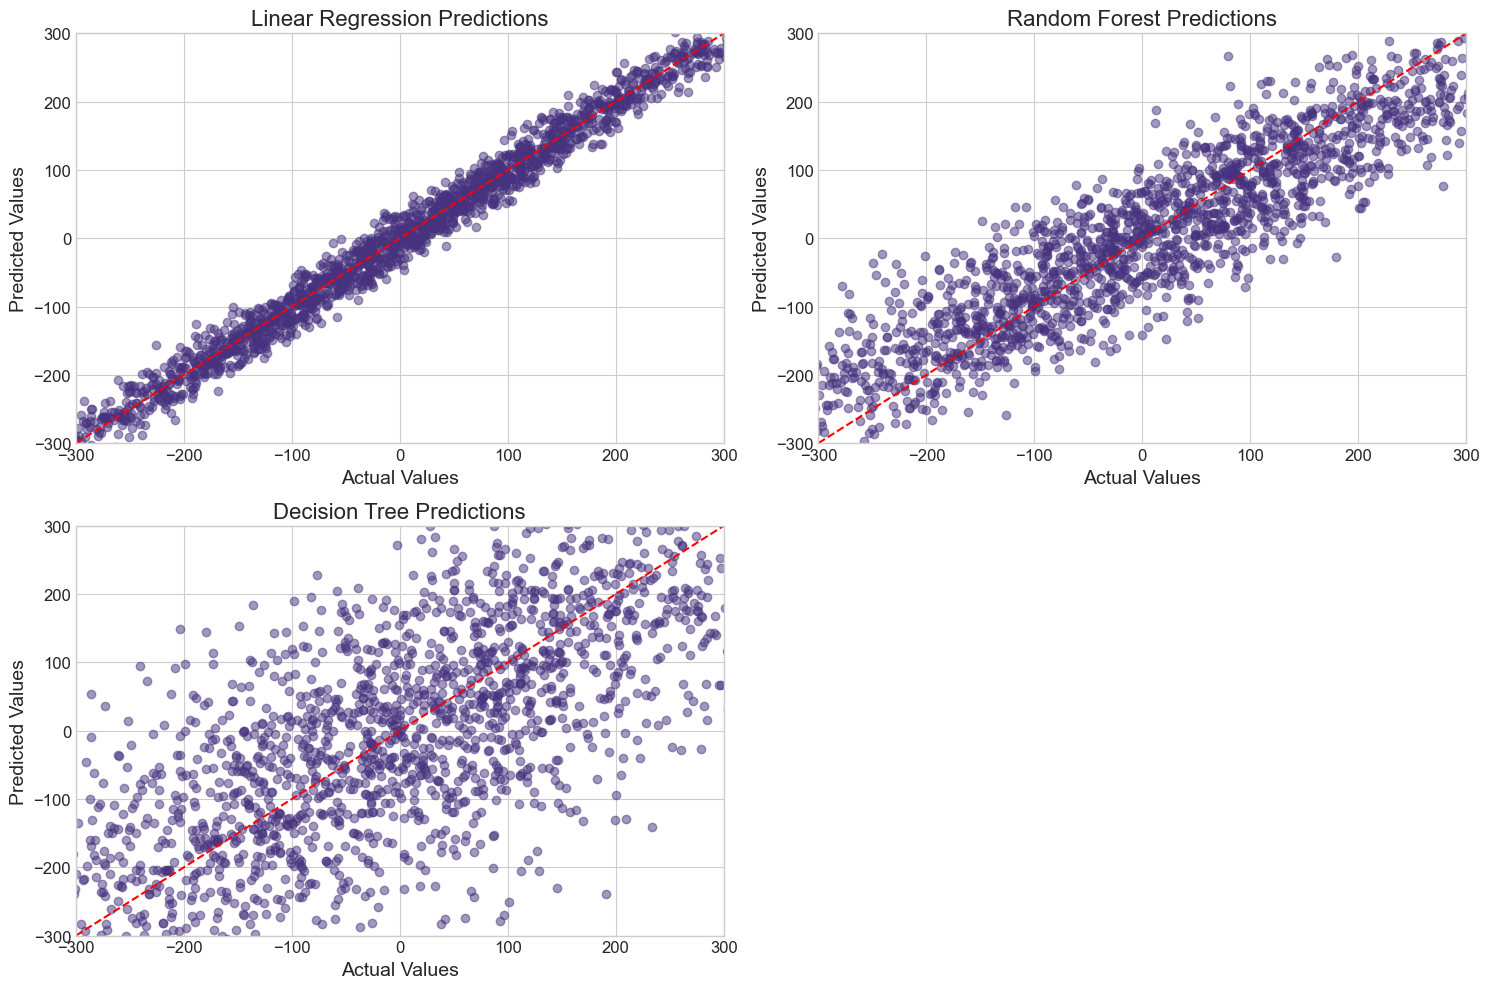

In [21]:
# Visualize predictions vs actual values
plt.figure(figsize=(15, 10))

for i, result in enumerate(results):
    plt.subplot(2, 2, i+1)
    plt.scatter(y_val, result['predictions'], alpha=0.5)
    plt.plot([-300, 300], [-300, 300], 'r--')  # Perfect prediction line
    plt.title(f"{result['model']} Predictions")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.xlim([-300, 300])
    plt.ylim([-300, 300])

plt.tight_layout()
plt.show()

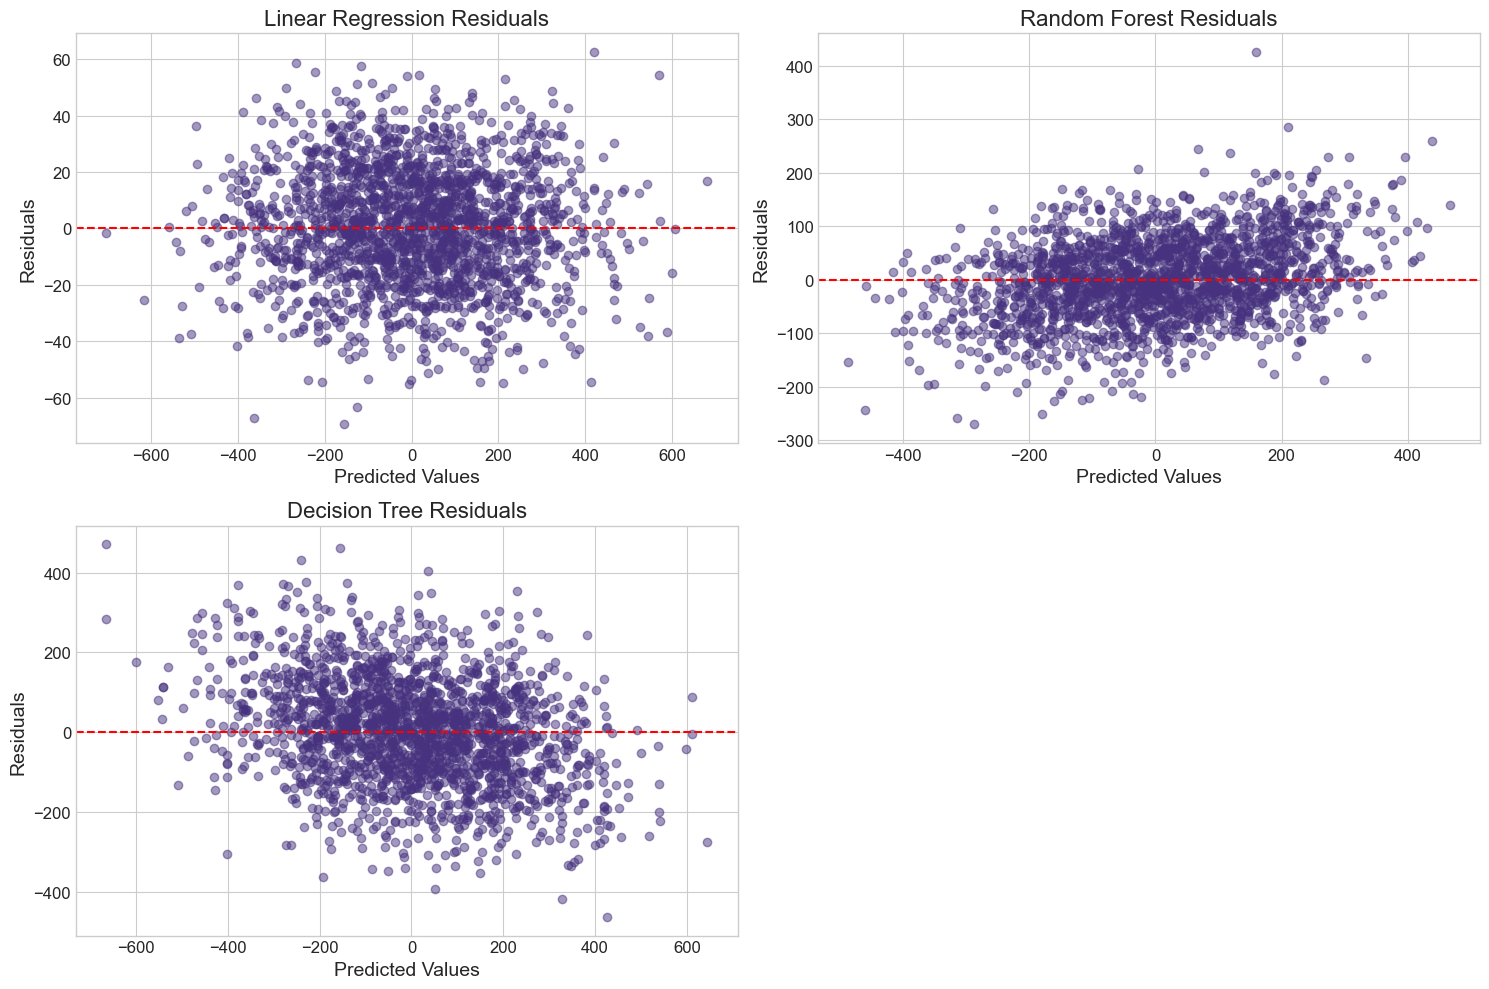

In [22]:
# Visualize residuals
plt.figure(figsize=(15, 10))

for i, result in enumerate(results):
    plt.subplot(2, 2, i+1)
    residuals = y_val - result['predictions']
    plt.scatter(result['predictions'], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f"{result['model']} Residuals")
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    
plt.tight_layout()
plt.show()

### When to Use Each Metric

Different regression metrics are suitable for different scenarios:

- **MSE/RMSE**: When larger errors are disproportionately more significant than smaller ones. For example, in financial predictions or when outliers are particularly important.

- **MAE**: When you want each error to contribute proportionally to the total error. Useful when the target variable doesn't have outliers or when you don't want to penalize outliers heavily.

- **R²**: When you want to understand how much better your model is compared to a simple average. Good for communicating results to non-technical stakeholders.

- **MAPE**: When comparing models across different scales or when percentage errors are more meaningful than absolute errors. Often used in forecasting and business contexts.

## 2.4 Bias-Variance Tradeoff

The [bias-variance tradeoff](https://www.geeksforgeeks.org/ml-bias-variance-trade-off/) is a central problem in machine learning that involves balancing two sources of error that prevent supervised learning algorithms from generalizing beyond their training set:

- **Bias**: Error due to overly simplistic assumptions in the learning algorithm. High bias can cause an algorithm to miss relevant relations between features and target outputs (underfitting).
- **Variance**: Error due to excessive sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model random noise in the training data rather than the intended outputs (overfitting).

The goal is to find the sweet spot that minimizes both bias and variance to achieve the best generalization performance.

Another interpretation of the error structure is:
1. **Bias²**: How far off the model's predictions are from the correct values on average.
2. **Variance**: How much the predictions vary for a given point across different realizations of the model.
3. **Irreducible Error**: The noise in the true relationship that cannot be modeled.

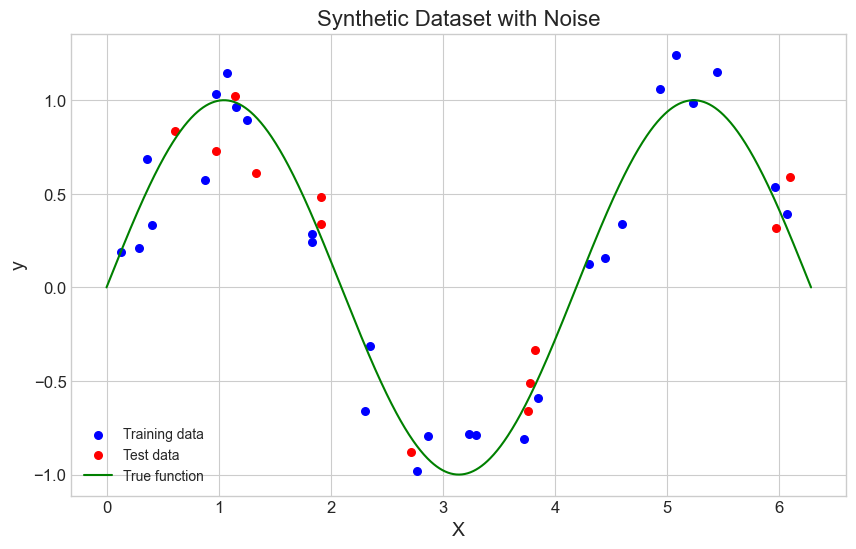

In [23]:
def true_function(X):
    """The underlying function we're trying to learn"""
    return np.sin(1.5 * X)

# Generate synthetic data
X = np.sort(np.random.uniform(0, 2*np.pi, 40))
y = true_function(X) + np.random.normal(0, 0.2, X.shape[0])

# Reshape X for scikit-learn
X_reshaped = X.reshape(-1, 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.3, random_state=42)

# Create fine grid for visualization
X_grid = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)

# Plot the synthetic data and the true function
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', s=30, label='Training data')
plt.scatter(X_test, y_test, color='red', s=30, label='Test data')
plt.plot(X_grid, true_function(X_grid), color='green', linestyle='-', label='True function')
plt.title('Synthetic Dataset with Noise')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

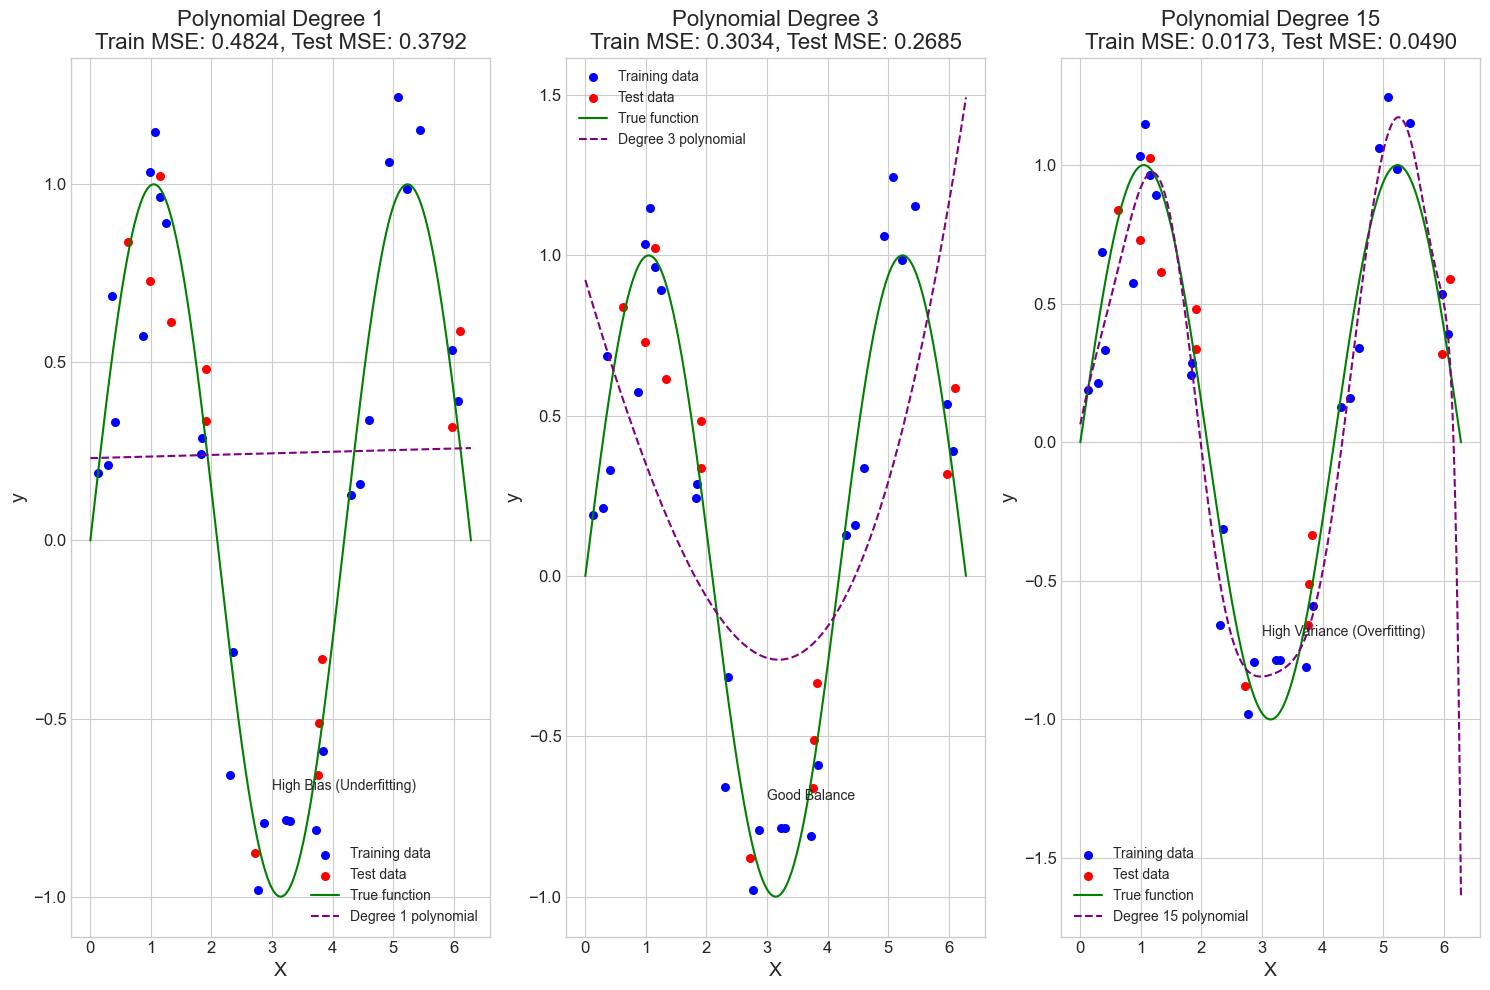

In [24]:
# Create models with different degrees of polynomial features
degrees = [1, 3, 15]  # Linear, cubic, and high degree polynomial

plt.figure(figsize=(15, 10))
for i, degree in enumerate(degrees):
    # Create and train the model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    grid_pred = model.predict(X_grid)
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    # Plot the results
    plt.subplot(1, 3, i+1)
    plt.scatter(X_train, y_train, color='blue', s=30, label='Training data')
    plt.scatter(X_test, y_test, color='red', s=30, label='Test data')
    plt.plot(X_grid, true_function(X_grid), color='green', linestyle='-', label='True function')
    plt.plot(X_grid, grid_pred, color='purple', linestyle='--', label=f'Degree {degree} polynomial')
    
    # Add error information
    plt.title(f'Polynomial Degree {degree}\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    if i == 0:
        plt.text(3, -0.7, "High Bias (Underfitting)")
    elif i == 1:
        plt.text(3, -0.7, "Good Balance")
    else:
        plt.text(3, -0.7, "High Variance (Overfitting)")
        
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
plt.tight_layout()
plt.show()

## 2.5 Regularization: A Way to Control the Bias-Variance Tradeoff

Regularization is a technique used to control model complexity and prevent overfitting.

We use Ridge Regression Regularization as example.

In standard linear regression, we minimize the sum of squared errors between our predictions and actual values. Ridge regression adds a penalty term to this objective function:

$$\text{minimize: } \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p} \beta_j^2$$

Where:
- The first term is the familiar ordinary least squares (OLS) cost function
- The second term is the penalty that shrinks coefficients toward zero
- $\alpha$ is the regularization strength (also called lambda in some texts)
- $\beta_j$ are the model coefficients

The key benefits of ridge regularization:

1. It reduces model complexity by shrinking coefficients toward zero (but never exactly to zero)
2. It helps prevent overfitting, especially when there are many features
3. It improves model stability when features are highly correlated (multicollinearity)
4. It provides a smooth way to control the bias-variance tradeoff

As $\alpha$ increases, the model becomes simpler (higher bias, lower variance). As $\alpha$ approaches zero, ridge regression approaches ordinary least squares regression.

Finding the optimal value of $\alpha$ is typically done using cross-validation, striking the perfect balance between underfitting and overfitting for your specific dataset.

In [ ]:
# Create a high-degree polynomial model with varying regularization
degree = 15  # High degree polynomial
alphas = [0, 0.001, 0.01, 0.1, 1, 10, 100]

plt.figure(figsize=(15, 10))

for i, alpha in enumerate(alphas):
    # Plot in a 2x4 grid
    plt.subplot(2, 4, i+1)
    
    # Create and train the model (Ridge regression with polynomial features)
    model = make_pipeline(
        PolynomialFeatures(degree),
        Ridge(alpha=alpha)
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    grid_pred = model.predict(X_grid[:-30])
    
    # Calculate errors
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    # Plot data points and predictions
    plt.scatter(X_train, y_train, color='blue', s=30, alpha=0.6, label='Training data')
    plt.plot(X_grid[:-30], true_function(X_grid[:-30]), color='green', linestyle='-', label='True function')
    plt.plot(X_grid[:-30], grid_pred, color='red', linestyle='--', label=f'Ridge (α={alpha})')
    
    # Add error information
    if alpha == 0:
        alpha_text = "0 (OLS)"
    else:
        alpha_text = str(alpha)
    plt.title(f'α={alpha_text}\nTrain MSE: {train_mse:.4f}\nTest MSE: {test_mse:.4f}')
    
    plt.xlabel('X')
    plt.ylabel('y')
    if i == 0:  # Only show legend for the first plot
        plt.legend()
    plt.grid(True)
    
plt.suptitle('Effect of Ridge Regularization (α) on a Degree 15 Polynomial Model', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

C:\Users\franc\PycharmProjects\DataScience\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.09698e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\franc\PycharmProjects\DataScience\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=9.79843e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\franc\PycharmProjects\DataScience\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.8333e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## BREAK

## 3. Validation Techniques <a id="validation"></a>

Now that we understand how to measure our model's performance, let's explore different validation techniques that help ensure our model will generalize well to new data.

### Hold-Out Validation

The simplest form of validation is hold-out validation, which we've already implemented by splitting our data into training, validation, and test sets. 

- **Training set**: Used to train the model
- **Validation set**: Used to tune hyperparameters and evaluate during development
- **Test set**: Used only once at the very end to get an unbiased estimate of the model's performance

While simple, hold-out validation can be problematic if:
- Your dataset is small
- The split doesn't represent the overall data distribution
- You need to tune many hyperparameters, which may lead to overfitting the validation set

### K-Fold Cross-Validation

K-fold cross-validation addresses many shortcomings of hold-out validation by:
1. Dividing the data into K equal parts (folds)
2. Training the model K times, each time using a different fold as the validation set and the remaining K-1 folds as the training set
3. Averaging the performance across all K runs

This approach provides a more robust performance estimate, especially for smaller datasets.

In [ ]:
# Perform 5-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    # Get MSE scores for each fold
    mse_scores = -cross_val_score(model, X_train_val, y_train_val, 
                                 scoring='neg_mean_squared_error', 
                                 cv=kf, n_jobs=-1)
    
    # Get R² scores for each fold
    r2_scores = cross_val_score(model, X_train_val, y_train_val, 
                               scoring='r2', 
                               cv=kf, n_jobs=-1)
    
    cv_results[name] = {
        'MSE': mse_scores,
        'RMSE': np.sqrt(mse_scores),
        'R2': r2_scores
    }
    
    print(f"--- {name} Cross-Validation Results ---")
    print(f"MSE: {mse_scores.mean():.2f} (±{mse_scores.std():.2f})")
    print(f"RMSE: {np.sqrt(mse_scores).mean():.2f} (±{np.sqrt(mse_scores).std():.2f})")
    print(f"R²: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})\n")

In [ ]:
cv_results

In [ ]:
# Visualize cross-validation results
plt.figure(figsize=(14, 6))

# Plot RMSE
plt.subplot(1, 2, 1)
rmse_means = [cv_results[model]['RMSE'].mean() for model in models.keys()]
rmse_stds = [cv_results[model]['RMSE'].std() for model in models.keys()]
plt.bar(models.keys(), rmse_means, yerr=rmse_stds, capsize=10, alpha=0.7)
plt.title('Cross-Validation RMSE by Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

# Plot R²
plt.subplot(1, 2, 2)
r2_means = [cv_results[model]['R2'].mean() for model in models.keys()]
r2_stds = [cv_results[model]['R2'].std() for model in models.keys()]
plt.bar(models.keys(), r2_means, yerr=r2_stds, capsize=10, alpha=0.7)
plt.title('Cross-Validation R² by Model')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Other Validation Techniques

Beyond basic k-fold cross-validation, there are several specialized techniques for different scenarios:

1. **Stratified K-Fold**: Ensures that each fold has approximately the same proportion of each target value. More commonly used for classification but can be adapted for regression by binning the target values.

2. **Time Series Cross-Validation**: For time-dependent data, where future samples shouldn't be used to predict past observations.

3. **Leave-One-Out Cross-Validation (LOOCV)**: A special case of k-fold where k equals the number of samples. Computationally expensive but useful for very small datasets.

4. **Nested Cross-Validation**: Uses an outer loop for performance estimation and an inner loop for hyperparameter tuning. Provides an unbiased estimate of the model's performance, especially when hyperparameter tuning is involved.

### Learning Curves

Visualizing model performance with increasing training set size:

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

dt = DecisionTreeClassifier(random_state=42)
X, y = load_iris(return_X_y=True)

# Compute learning curve
train_sizes, train_scores, test_scores = learning_curve(
    dt, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title('Learning Curves')
plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Cross-validation Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

## 4. Model Selection Strategies

### 4.1 Grid Search Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Load dataset
X, y = load_iris(return_X_y=True)

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Perform Grid Search
grid_search = GridSearchCV(
    SVC(), param_grid, cv=5, 
    scoring='accuracy', n_jobs=-1
)
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

### 4.2 Defining a Suite of Models to Compare

We'll define a collection of regression models with their default parameters. Later, we'll compare these and also use optimized versions.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

In [ ]:
# Define a dictionary of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

print(f"Number of models to compare: {len(models)}")

### 4.3 Creating a Model Evaluation Function

Let's define a function that will evaluate each model using cross-validation and multiple metrics.

In [ ]:
def evaluate_model(model, X, y, cv=5):
    """
    Evaluate a regression model using cross-validation and multiple metrics.
    
    Parameters:
    -----------
    model : estimator object
        The model to evaluate
    X : DataFrame
        Feature matrix
    y : Series
        Target vector
    cv : int, default=5
        Number of cross-validation folds
        
    Returns:
    --------
    dict : Dictionary of evaluation results
    """
    # Create a KFold object for consistent splitting across metrics
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Calculate different metrics using cross-validation
    neg_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
    ev_scores = cross_val_score(model, X, y, cv=kf, scoring='explained_variance')
    
    # Convert negative MSE and MAE to positive for easier interpretation
    mse_scores = -neg_mse_scores
    rmse_scores = np.sqrt(mse_scores)
    mae_scores = -mae_scores
    
    # Gather results
    results = {
        'RMSE': {
            'mean': rmse_scores.mean(),
            'std': rmse_scores.std(),
            'values': rmse_scores
        },
        'MAE': {
            'mean': mae_scores.mean(),
            'std': mae_scores.std(),
            'values': mae_scores
        },
        'R²': {
            'mean': r2_scores.mean(),
            'std': r2_scores.std(),
            'values': r2_scores
        },
        'Explained Variance': {
            'mean': ev_scores.mean(),
            'std': ev_scores.std(),
            'values': ev_scores
        }
    }
    
    return results

### 4.4 Evaluating All Models with Cross-Validation

Now, let's evaluate all our models using the function we defined.

In [ ]:
# Create a dictionary to store results for all models
all_results = {}

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Create a pipeline that scales the data first (important for some models like SVR and KNN)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Evaluate the model pipeline
    all_results[name] = evaluate_model(pipeline, X_train, y_train, cv=5)
    
print("\nEvaluation complete!")

### 4.5 Comparing Models Using Multiple Metrics

Let's create visualizations to compare the performance of all models across different metrics.

In [ ]:
def plot_model_comparison(results, metric):
    """
    Create a bar plot comparing models on a specific metric.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
    metric : str
        The metric to plot ('RMSE', 'MAE', 'R²', or 'Explained Variance')
    """
    # Extract mean values and standard deviations for the metric
    means = [results[model][metric]['mean'] for model in results]
    stds = [results[model][metric]['std'] for model in results]
    model_names = list(results.keys())
    
    # Sort by performance (lower is better for RMSE and MAE, higher is better for R² and Explained Variance)
    if metric in ['RMSE', 'MAE']:
        sorted_indices = np.argsort(means)
        title_text = f"Model Comparison by {metric} (Lower is Better)"
    else:
        sorted_indices = np.argsort(means)[::-1]  # Reverse for higher is better
        title_text = f"Model Comparison by {metric} (Higher is Better)"
    
    sorted_means = [means[i] for i in sorted_indices]
    sorted_stds = [stds[i] for i in sorted_indices]
    sorted_names = [model_names[i] for i in sorted_indices]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    bars = plt.bar(sorted_names, sorted_means, yerr=sorted_stds, capsize=10,
                  color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(title_text)
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar, value in zip(bars, sorted_means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02 * max(sorted_means),
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Create a comparison table
def create_comparison_table(results):
    """
    Create a pandas DataFrame summarizing model performance across all metrics.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
        
    Returns:
    --------
    DataFrame : Summary table of model performance
    """
    # Initialize lists to store data
    models = []
    rmse_means = []
    rmse_stds = []
    mae_means = []
    mae_stds = []
    r2_means = []
    r2_stds = []
    ev_means = []
    ev_stds = []
    
    # Extract data
    for model_name, model_results in results.items():
        models.append(model_name)
        rmse_means.append(model_results['RMSE']['mean'])
        rmse_stds.append(model_results['RMSE']['std'])
        mae_means.append(model_results['MAE']['mean'])
        mae_stds.append(model_results['MAE']['std'])
        r2_means.append(model_results['R²']['mean'])
        r2_stds.append(model_results['R²']['std'])
        ev_means.append(model_results['Explained Variance']['mean'])
        ev_stds.append(model_results['Explained Variance']['std'])
    
    # Create DataFrame
    df = pd.DataFrame({
        'Model': models,
        'RMSE (mean)': rmse_means,
        'RMSE (std)': rmse_stds,
        'MAE (mean)': mae_means,
        'MAE (std)': mae_stds,
        'R² (mean)': r2_means,
        'R² (std)': r2_stds,
        'Explained Variance (mean)': ev_means,
        'Explained Variance (std)': ev_stds
    })
    
    # Format the DataFrame for better readability
    for col in df.columns:
        if '(mean)' in col or '(std)' in col:
            df[col] = df[col].round(4)
    
    return df

# Plot comparisons for each metric
for metric in ['RMSE', 'MAE', 'R²', 'Explained Variance']:
    plot_model_comparison(all_results, metric)

# Create and display a comprehensive comparison table
comparison_table = create_comparison_table(all_results)
comparison_table.sort_values(by='RMSE (mean)')

### 4.6 Ranking Models by Multiple Criteria

Let's create a function to rank our models considering multiple metrics simultaneously.

In [ ]:
def rank_models(results, weights=None):
    """
    Rank models based on multiple metrics with optional weighting.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing evaluation results for all models
    weights : dict, optional
        Dictionary with metrics as keys and weights as values
        Default weights give equal importance to all metrics
        
    Returns:
    --------
    DataFrame : Ranked models with composite scores
    """
    # Define default weights if none provided
    if weights is None:
        weights = {'RMSE': 0.25, 'MAE': 0.25, 'R²': 0.25, 'Explained Variance': 0.25}
    
    # Check that weights sum to 1
    weight_sum = sum(weights.values())
    if abs(weight_sum - 1.0) > 1e-10:  # Allow for floating point imprecision
        raise ValueError(f"Weights must sum to 1, but they sum to {weight_sum}")
    
    # Extract model names and initialize score dictionaries
    model_names = list(results.keys())
    normalized_scores = {model: 0 for model in model_names}
    
    # For each metric, normalize scores and calculate weighted contribution
    for metric, weight in weights.items():
        # Extract metric values for all models
        metric_values = [results[model][metric]['mean'] for model in model_names]
        
        # Normalize scores (0-1 scale, 1 is best)
        if metric in ['RMSE', 'MAE']:  # Lower is better
            min_val = min(metric_values)
            max_val = max(metric_values)
            # Avoid division by zero
            if max_val == min_val:
                normalized = [1.0 for _ in metric_values]
            else:
                normalized = [1 - (val - min_val) / (max_val - min_val) for val in metric_values]
        else:  # Higher is better for R² and Explained Variance
            min_val = min(metric_values)
            max_val = max(metric_values)
            # Avoid division by zero
            if max_val == min_val:
                normalized = [1.0 for _ in metric_values]
            else:
                normalized = [(val - min_val) / (max_val - min_val) for val in metric_values]
        
        # Add weighted normalized score to each model's total
        for i, model in enumerate(model_names):
            normalized_scores[model] += weight * normalized[i]
    
    # Create a DataFrame with the results
    rank_df = pd.DataFrame({
        'Model': model_names,
        'Composite Score': [normalized_scores[model] for model in model_names]
    })
    
    # Sort by composite score in descending order
    rank_df = rank_df.sort_values('Composite Score', ascending=False).reset_index(drop=True)
    
    # Add rank column
    rank_df.index = rank_df.index + 1
    rank_df = rank_df.rename_axis('Rank').reset_index()
    
    # Round scores for display
    rank_df['Composite Score'] = rank_df['Composite Score'].round(4)
    
    return rank_df

# Let's rank our models with default weights (equal importance)
default_ranking = rank_models(all_results)
print("Model ranking with equal weighting of metrics:")
display(default_ranking)


# Time Series Forecasting Evaluation Metrics

## 1. Introduction to Time Series Evaluation <a name="introduction"></a>

Evaluating time series forecasting models presents unique challenges compared to standard machine learning tasks. Time-dependent data often exhibits seasonal patterns, trends, and various degrees of stationarity. The choice of evaluation metric significantly impacts model selection and parameter tuning.

Key considerations when choosing evaluation metrics for time series:

- **Scale sensitivity**: Is the metric affected by the scale of the data?
- **Outlier sensitivity**: How does the metric handle extreme values?
- **Zero/small values**: Does the metric break down with zeros or near-zero values?
- **Interpretability**: How easily can stakeholders understand the metric?
- **Directionality**: Does the forecast direction matter more than magnitude?
- **Asymmetric costs**: Are over-predictions and under-predictions equally problematic?

We'll explore metrics that address these different aspects of forecast evaluation.

## 2. Setup and Sample Data Generation <a name="setup"></a>

Let's first import the necessary libraries and generate some sample data to work with.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Generate synthetic time series data
def generate_sample_data(n=100, with_trend=True, with_seasonality=True, with_noise=True):

    # Create time index
    time_idx = pd.date_range(start='2023-01-01', periods=n, freq='D')
    
    # Base component
    base = 100
    
    # Trend component
    trend = np.linspace(0, 30, n) if with_trend else np.zeros(n)
    
    # Seasonal component (weekly pattern)
    seasonality = 15 * np.sin(2 * np.pi * np.arange(n) / 7) if with_seasonality else np.zeros(n)
    
    # Noise component
    noise = np.random.normal(0, 5, n) if with_noise else np.zeros(n)
    
    # Combine components
    actual = base + trend + seasonality + noise
    
    # Create different forecast versions with varying accuracy
    forecast1 = actual + np.random.normal(0, 10, n)  # Good forecast
    forecast2 = actual + np.random.normal(5, 15, n)  # Biased forecast
    forecast3 = base + trend + np.random.normal(0, 10, n)  # Missing seasonality
    forecast4 = actual * 1.2  # Scaled forecast (systematically higher)
    
    # Create a dataframe
    df = pd.DataFrame({
        'ds': time_idx,
        'actual': actual,
        'forecast_good': forecast1,
        'forecast_biased': forecast2,
        'forecast_no_seasonality': forecast3,
        'forecast_scaled': forecast4
    })
    
    # Add special cases for testing robustness
    df.loc[10:15, 'actual'] = 0  # Zero values
    df.loc[20, 'actual'] = 400  # Outlier
    
    return df

In [ ]:
# Generate sample data and visualize
data = generate_sample_data(n=100)

plt.figure(figsize=(14, 6))
plt.plot(data['ds'], data['actual'], 'k-', label='Actual')
plt.plot(data['ds'], data['forecast_good'], 'b-', alpha=0.7, label='Good Forecast')
plt.plot(data['ds'], data['forecast_biased'], 'r-', alpha=0.7, label='Biased Forecast')
plt.plot(data['ds'], data['forecast_no_seasonality'], 'g-', alpha=0.7, label='No Seasonality')
plt.plot(data['ds'], data['forecast_scaled'], 'y-', alpha=0.7, label='Scaled Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data with Various Forecasts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Now we have our sample data with several forecast versions to evaluate. Let's implement different metrics to assess these forecasts.

## 3. Scale-Dependent Metrics <a name="scale-dependent"></a>

Scale-dependent metrics are the most straightforward and commonly used. However, they can't be used to compare forecasts across different scales or units.

### 3.1 Mean Absolute Error (MAE)

The Mean Absolute Error is the average absolute difference between predicted and actual values. It's easy to interpret as it's in the same unit as the original data.

$$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

Where:
- $n$ is the number of observations
- $y_i$ is the actual value
- $\hat{y}_i$ is the predicted value

In [ ]:
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Calculate MAE for each forecast
mae_good = calculate_mae(data['actual'], data['forecast_good'])
mae_biased = calculate_mae(data['actual'], data['forecast_biased'])
mae_no_seasonality = calculate_mae(data['actual'], data['forecast_no_seasonality'])
mae_scaled = calculate_mae(data['actual'], data['forecast_scaled'])

print(f"MAE (Good Forecast): {mae_good:.2f}")
print(f"MAE (Biased Forecast): {mae_biased:.2f}")
print(f"MAE (No Seasonality): {mae_no_seasonality:.2f}")
print(f"MAE (Scaled Forecast): {mae_scaled:.2f}")

### 3.2 Mean Squared Error (MSE)

The Mean Squared Error calculates the average of squared differences between predicted and actual values. MSE gives higher weight to large errors, making it more sensitive to outliers.

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

In [ ]:
def calculate_mse(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

# Calculate MSE for each forecast
mse_good = calculate_mse(data['actual'], data['forecast_good'])
mse_biased = calculate_mse(data['actual'], data['forecast_biased'])
mse_no_seasonality = calculate_mse(data['actual'], data['forecast_no_seasonality'])
mse_scaled = calculate_mse(data['actual'], data['forecast_scaled'])

print(f"MSE (Good Forecast): {mse_good:.2f}")
print(f"MSE (Biased Forecast): {mse_biased:.2f}")
print(f"MSE (No Seasonality): {mse_no_seasonality:.2f}")
print(f"MSE (Scaled Forecast): {mse_scaled:.2f}")

### 3.3 Root Mean Squared Error (RMSE)

The Root Mean Squared Error is the square root of MSE. It brings the error back to the same scale as the original data, making it more interpretable while still penalizing large errors more.

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

In [ ]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(calculate_mse(y_true, y_pred))

# Calculate RMSE for each forecast
rmse_good = calculate_rmse(data['actual'], data['forecast_good'])
rmse_biased = calculate_rmse(data['actual'], data['forecast_biased'])
rmse_no_seasonality = calculate_rmse(data['actual'], data['forecast_no_seasonality'])
rmse_scaled = calculate_rmse(data['actual'], data['forecast_scaled'])

print(f"RMSE (Good Forecast): {rmse_good:.2f}")
print(f"RMSE (Biased Forecast): {rmse_biased:.2f}")
print(f"RMSE (No Seasonality): {rmse_no_seasonality:.2f}")
print(f"RMSE (Scaled Forecast): {rmse_scaled:.2f}")

Let's compare the scale-dependent metrics side by side:

In [ ]:
scale_dependent_metrics = pd.DataFrame({
    'Forecast Type': ['Good', 'Biased', 'No Seasonality', 'Scaled'],
    'MAE': [mae_good, mae_biased, mae_no_seasonality, mae_scaled],
    'MSE': [mse_good, mse_biased, mse_no_seasonality, mse_scaled],
    'RMSE': [rmse_good, rmse_biased, rmse_no_seasonality, rmse_scaled]
})

scale_dependent_metrics.set_index('Forecast Type', inplace=True)
scale_dependent_metrics

### Observations on Scale-Dependent Metrics

- All three metrics (MAE, MSE, RMSE) show that the "Good Forecast" performs best, as expected.
- The "Scaled Forecast" performs worst according to these metrics, showing the impact of systematic bias.
- MSE and RMSE penalize larger errors more heavily than MAE, which is why the difference between forecasts is more pronounced for these metrics.
- The actual values of these metrics are in the same units as the original data (for MAE and RMSE) or squared units (for MSE).
- These metrics can't be used to compare forecasts for different time series with different scales.

## 4. Percentage Errors <a name="percentage-errors"></a>

Percentage errors express the error as a percentage of the actual values, making them scale-independent. However, they can face issues when actual values are close to or equal to zero.

### 4.1 Mean Absolute Percentage Error (MAPE)

MAPE calculates the average of absolute percentage errors. It's scale-independent and easily interpretable, but undefined for zero values and biased towards lower forecasts.

$$\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$$

In [ ]:
def calculate_mape(y_true, y_pred, epsilon=1e-10):
    # Filter out zero values to avoid division by zero
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    if len(y_true_filtered) == 0:
        return np.nan
        
    return 100 * np.mean(np.abs((y_true_filtered - y_pred_filtered) / (y_true_filtered + epsilon)))

# Calculate MAPE for each forecast
mape_good = calculate_mape(data['actual'], data['forecast_good'])
mape_biased = calculate_mape(data['actual'], data['forecast_biased'])
mape_no_seasonality = calculate_mape(data['actual'], data['forecast_no_seasonality'])
mape_scaled = calculate_mape(data['actual'], data['forecast_scaled'])

print(f"MAPE (Good Forecast): {mape_good:.2f}%")
print(f"MAPE (Biased Forecast): {mape_biased:.2f}%")
print(f"MAPE (No Seasonality): {mape_no_seasonality:.2f}%")
print(f"MAPE (Scaled Forecast): {mape_scaled:.2f}%")

### 4.2 Symmetric Mean Absolute Percentage Error (SMAPE)

SMAPE is a variation of MAPE that is symmetric, meaning it treats over-forecasting and under-forecasting equally. It's bounded between 0% and 200%.

$$\text{SMAPE} = \frac{200\%}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{|y_i| + |\hat{y}_i|}$$

In [ ]:
def calculate_smape(y_true, y_pred, epsilon=1e-10):
    # Handle cases where both y_true and y_pred are zero
    mask = (np.abs(y_true) + np.abs(y_pred)) != 0
    
    if np.sum(mask) == 0:
        return 0.0
        
    return 200 * np.mean(np.abs(y_pred[mask] - y_true[mask]) / (np.abs(y_true[mask]) + np.abs(y_pred[mask]) + epsilon))

# Calculate SMAPE for each forecast
smape_good = calculate_smape(data['actual'], data['forecast_good'])
smape_biased = calculate_smape(data['actual'], data['forecast_biased'])
smape_no_seasonality = calculate_smape(data['actual'], data['forecast_no_seasonality'])
smape_scaled = calculate_smape(data['actual'], data['forecast_scaled'])

print(f"SMAPE (Good Forecast): {smape_good:.2f}%")
print(f"SMAPE (Biased Forecast): {smape_biased:.2f}%")
print(f"SMAPE (No Seasonality): {smape_no_seasonality:.2f}%")
print(f"SMAPE (Scaled Forecast): {smape_scaled:.2f}%")

Let's compare the percentage error metrics:

In [ ]:
percentage_metrics = pd.DataFrame({
    'Forecast Type': ['Good', 'Biased', 'No Seasonality', 'Scaled'],
    'MAPE (%)': [mape_good, mape_biased, mape_no_seasonality, mape_scaled],
    'SMAPE (%)': [smape_good, smape_biased, smape_no_seasonality, smape_scaled]
})

percentage_metrics.set_index('Forecast Type', inplace=True)
percentage_metrics

### Observations on Percentage Error Metrics

- Percentage errors allow us to compare across different scales.
- MAPE can be heavily influenced by zero or near-zero values, which we had to handle specially.
- SMAPE is more robust to outliers and zero values, though it's still not perfect.
- The "Good Forecast" still performs best, but now "Scaled Forecast" performs better with SMAPE than with scale-dependent metrics, showing that the error is more proportional.
- Note how our handling of zeros impacts the results - in real applications, the treatment of zero/small values needs careful consideration.

## 5. Scaled Errors <a name="scaled-errors"></a>

Scaled errors compare the forecast errors to a baseline method, providing a relative measure of performance.

### Mean Absolute Scaled Error (MASE)

MASE compares the mean absolute error of the forecast to the mean absolute error of a naive forecast. For non-seasonal data, the naive forecast is simply the previous observation (one-step naive forecast). For seasonal data, the naive forecast is the value from the same season in the previous year.

$$\text{MASE} = \frac{\frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|}{\frac{1}{T-m} \sum_{t=m+1}^{T} |y_t - y_{t-m}|}$$

where $m$ is the seasonal period (1 for non-seasonal data) and $T$ is the number of observations in the training set.

**Advantages**:
- Scale-independent
- Handles zero values well
- Provides context by comparing to a naive benchmark
- Less affected by outliers than squared error metrics

**Disadvantages**:
- Less intuitive to interpret
- Depends on the choice of benchmark method

In [ ]:
def calculate_mase(y_true, y_pred, seasonal_period=1):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the error of the forecast
    forecast_errors = np.abs(y_true - y_pred)
    
    # Calculate the error of the naive forecast (seasonal if seasonal_period > 1)
    naive_errors = np.abs(y_true[seasonal_period:] - y_true[:-seasonal_period])
    
    # Return MASE
    if len(naive_errors) == 0 or np.sum(naive_errors) == 0:
        return np.nan
        
    return np.mean(forecast_errors) / np.mean(naive_errors)

# Calculate MASE for each forecast (using both non-seasonal and weekly seasonal periods)
mase_good_nonseasonal = calculate_mase(data['actual'].tolist(), data['forecast_good'].tolist())
mase_biased_nonseasonal = calculate_mase(data['actual'], data['forecast_biased'])
mase_no_seasonality_nonseasonal = calculate_mase(data['actual'], data['forecast_no_seasonality'])
mase_scaled_nonseasonal = calculate_mase(data['actual'], data['forecast_scaled'])

mase_good_weekly = calculate_mase(data['actual'], data['forecast_good'], seasonal_period=7)
mase_biased_weekly = calculate_mase(data['actual'], data['forecast_biased'], seasonal_period=7)
mase_no_seasonality_weekly = calculate_mase(data['actual'], data['forecast_no_seasonality'], seasonal_period=7)
mase_scaled_weekly = calculate_mase(data['actual'], data['forecast_scaled'], seasonal_period=7)

print("Non-seasonal MASE (uses previous day as baseline):")
print(f"MASE (Good Forecast): {mase_good_nonseasonal:.2f}")
print(f"MASE (Biased Forecast): {mase_biased_nonseasonal:.2f}")
print(f"MASE (No Seasonality): {mase_no_seasonality_nonseasonal:.2f}")
print(f"MASE (Scaled Forecast): {mase_scaled_nonseasonal:.2f}")

print("\nWeekly Seasonal MASE (uses same day last week as baseline):")
print(f"MASE (Good Forecast): {mase_good_weekly:.2f}")
print(f"MASE (Biased Forecast): {mase_biased_weekly:.2f}")
print(f"MASE (No Seasonality): {mase_no_seasonality_weekly:.2f}")
print(f"MASE (Scaled Forecast): {mase_scaled_weekly:.2f}")

### Interpretation of MASE

- MASE < 1: The forecast is better than the naive forecast
- MASE = 1: The forecast is as good as the naive forecast
- MASE > 1: The forecast is worse than the naive forecast

MASE provides a clear benchmark for evaluating forecasting models. A model should at least beat the naive forecast to be considered useful.

## 6. Distribution-Based Metrics <a id='distribution-based'></a>

Distribution-based metrics evaluate probabilistic forecasts or prediction intervals rather than point forecasts. These are becoming increasingly important as forecasting methods move beyond single-point predictions to provide full predictive distributions.

### Continuous Ranked Probability Score (CRPS)

CRPS measures the compatibility between a predicted cumulative distribution function (CDF) and the observed value. It's a proper scoring rule for probabilistic forecasts, meaning it encourages honest reporting of predictive distributions.

$$\text{CRPS} = \int_{-\infty}^{\infty} (F(y) - \mathbf{1}\{y \geq y^o\})^2 dy$$

where $F(y)$ is the CDF of the forecast distribution, and $\mathbf{1}\{y \geq y^o\}$ is the indicator function equal to 1 if $y \geq y^o$ and 0 otherwise, with $y^o$ being the observed value.

**Advantages**:
- Evaluates the entire predictive distribution, not just a point forecast
- Proper scoring rule that encourages accurate probability assessments
- Reduces to MAE for deterministic forecasts

**Disadvantages**:
- More complex to compute
- Less intuitive to interpret
- Requires probabilistic forecasts

In [ ]:
# For CRPS calculation, we'll use a simplified approach using Monte Carlo samples
# In practice, you might use libraries like properscoring or specialized functions

def calculate_crps(actual, forecast_mean, forecast_std, n_samples=1000):
    """Calculate CRPS using Monte Carlo samples from a normal distribution
    
    This is a simplified implementation for educational purposes.
    In practice, use specialized libraries.
    """
    crps_values = []
    
    for i in range(len(actual)):
        # Generate samples from the forecast distribution
        samples = np.random.normal(forecast_mean[i], forecast_std[i], n_samples)
        samples.sort()  # Sort for the empirical CDF
        
        # Calculate the CRPS
        crps_i = 0
        for j in range(n_samples-1):
            # Width of the interval
            width = samples[j+1] - samples[j]
            
            # Height of the squared difference between the CDF and the indicator function
            cdf_value = (j+1) / n_samples
            indicator = 1.0 if samples[j] >= actual[i] else 0.0
            height = (cdf_value - indicator) ** 2
            
            # Add the area to the integral
            crps_i += width * height
            
        crps_values.append(crps_i)
    
    return np.mean(crps_values)

# Let's assume our forecast has a standard deviation proportional to the forecast value
forecast_std = data['forecast_good'] * 0.1  # 10% of the forecast value

# Calculate CRPS
crps = calculate_crps(data['actual'], data['forecast_good'], forecast_std)
print(f"CRPS: {crps:.4f}")

# Visualize a probabilistic forecast with prediction intervals
plt.figure(figsize=(14, 7))
plt.plot(data['actual'], label='Actual')
plt.plot(data['forecast_good'], label='Forecast Mean')

# Add 90% prediction interval
upper_90 = data['forecast_good'] + 1.645 * forecast_std
lower_90 = data['forecast_good'] - 1.645 * forecast_std
plt.fill_between(range(len(data['forecast_good'])), lower_90, upper_90, alpha=0.2, color='blue', label='90% Prediction Interval')

plt.title('Probabilistic Forecast with 90% Prediction Interval')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Let's show the empirical CDF for a few time points
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, idx in enumerate([0, 5, 10, 30]):
    if idx < len(data['actual']):
        # Generate samples for the empirical CDF
        samples = np.random.normal(data['forecast_good'][idx], forecast_std[idx], 1000)
        samples.sort()
        
        # Plot the empirical CDF
        cdf = np.arange(1, len(samples) + 1) / len(samples)
        axes[i].plot(samples, cdf, label='Forecast CDF')
        
        # Plot the actual observation as a step function
        x_values = np.linspace(min(samples), max(samples), 1000)
        y_values = np.where(x_values >= data['actual'][idx], 1, 0)
        axes[i].plot(x_values, y_values, 'r--', label='Observed Value')
        
        # Mark the actual observation
        axes[i].axvline(data['actual'][idx], color='r', linestyle=':')
        
        axes[i].set_title(f'Time {idx}: Forecast vs. Actual')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Cumulative Probability')
        axes[i].grid(True)
        axes[i].legend()

plt.tight_layout()
plt.show()

## 7. Time-Specific Metrics <a id="time-specific"></a>

Time series often have special characteristics like seasonality, trends, or varying importance across different time periods. Time-specific metrics account for these characteristics.

### 7.1 Weighted MAPE

Weighted MAPE (WMAPE) assigns different weights to different time periods, allowing us to emphasize specific periods that are more important for our analysis.

$$\text{WMAPE} = \frac{\sum_{i=1}^{n} w_i |y_i - \hat{y}_i|}{\sum_{i=1}^{n} w_i |y_i|}$$

Where:
- $w_i$ is the weight assigned to time period $i$
- $y_i$ is the actual value
- $\hat{y}_i$ is the forecasted value

In [ ]:
# Define the weighted MAPE function
def wmape(y_true, y_pred, weights=None):
    """Calculate Weighted Mean Absolute Percentage Error.
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    weights (array-like, optional): Weights for each observation
    
    Returns:
    float: Weighted MAPE value
    """
    if weights is None:
        weights = np.ones_like(y_true)
        
    # Avoid division by zero
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    
    return np.sum(weights[mask] * np.abs(y_true[mask] - y_pred[mask])) / np.sum(weights[mask] * np.abs(y_true[mask]))

# Let's create some custom weights
# For example, we might want to emphasize recent observations more
n = data.shape[0]
recency_weights = np.linspace(0.5, 1.5, n)  # Increasing weights over time

# Calculate standard MAPE (equal weights)
standard_mape = wmape(data['actual'], data['forecast_good'])

# Calculate weighted MAPEs
recency_wmape = wmape(data['actual'], data['forecast_good'], recency_weights)

print(f"Standard MAPE: {standard_mape:.4f}")
print(f"Recency-Weighted MAPE: {recency_wmape:.4f}")

<a id='real-world'></a>
## 9. Real-World Example

In this section, we'll apply the metrics we've learned to a real-world dataset. We'll use a retail sales dataset, which is a common time series forecasting scenario in business analytics.

In [ ]:
# Let's load a real-world retail sales dataset
# Using a sample of the online retail dataset
# You could replace this with your own dataset

# For this example, we'll generate a realistic retail sales dataset
np.random.seed(42)
date_rng = pd.date_range(start='2019-01-01', end='2022-12-31', freq='D')
df = pd.DataFrame(date_rng, columns=['date'])

# Create base level
level = 1000
# Add trend
trend = np.linspace(0, 500, len(date_rng))
# Add seasonality (weekly and yearly)
weekly = 50 * np.sin(np.arange(len(date_rng)) * (2 * np.pi / 7))
yearly = 300 * np.sin(np.arange(len(date_rng)) * (2 * np.pi / 365))
# Add random noise
noise = np.random.normal(0, 50, len(date_rng))

# Combine all components
df['sales'] = level + trend + weekly + yearly + noise
df['sales'] = df['sales'].clip(lower=0)  # Ensure no negative sales

# Set date as index
df.set_index('date', inplace=True)

# Display first few rows
print("Dataset preview:")
df.head()

In [ ]:
# Visualize the complete dataset
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['sales'])
plt.title('Daily Retail Sales Data (2019-2022)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9.1 Data Preparation and Train-Test Split

Before we apply forecasting models, we need to split our data into training and testing sets. In time series forecasting, we typically use earlier periods for training and later periods for testing, respecting the temporal nature of the data.

In [ ]:
# Split data into train and test sets (last 3 months for testing)
train = df[:'2022-09-30']
test = df['2022-10-01':]

print(f"Training data: {train.shape[0]} days")
print(f"Testing data: {test.shape[0]} days")

# Visualize the train-test split
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['sales'], label='Training Data')
plt.plot(test.index, test['sales'], label='Testing Data', color='red')
plt.title('Train-Test Split for Retail Sales Data', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9.2 Forecasting Models Implementation

Let's implement and compare several forecasting models:
1. Naive Forecast (last observed value)
2. Seasonal Naive (same value from last season)
3. Exponential Smoothing
4. ARIMA model

In [ ]:
# Initialize a DataFrame to store all forecasts
forecasts = pd.DataFrame(index=test.index)
forecasts['actual'] = test['sales']

# 1. Naive Forecast (using last observed value)
forecasts['naive'] = train['sales'].iloc[-1]

# 2. Seasonal Naive (using value from same day in the previous week)
forecasts['seasonal_naive'] = [train['sales'].iloc[-(i % 7 + 7)] for i in range(len(test))]

# 3. Exponential Smoothing
# Using Triple Exponential Smoothing (Holt-Winters) with weekly seasonality
hw_model = ExponentialSmoothing(
    train['sales'],
    seasonal_periods=7,
    trend='add',
    seasonal='add',
    use_boxcox=True
)
hw_fit = hw_model.fit(optimized=True)
forecasts['exponential_smoothing'] = hw_fit.forecast(len(test))

# 4. ARIMA model
# Using ARIMA(1,1,1)(1,1,0)7 for weekly seasonality
arima_model = ARIMA(
    train['sales'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 0, 7)
)
arima_fit = arima_model.fit()
forecasts['arima'] = arima_fit.forecast(len(test))

# Display first few rows of forecasts
forecasts.head()

In [ ]:
# Visualize the forecasts
plt.figure(figsize=(15, 8))

# Show the last 365 days of training data for context
plt.plot(train.index[-365:], train['sales'][-365:], label='Training Data', color='black', alpha=0.5)

# Plot actual values and forecasts
plt.plot(forecasts.index, forecasts['actual'], label='Actual Values', linewidth=2)
plt.plot(forecasts.index, forecasts['naive'], label='Naive Forecast', linestyle='--')
plt.plot(forecasts.index, forecasts['seasonal_naive'], label='Seasonal Naive', linestyle='--')
plt.plot(forecasts.index, forecasts['exponential_smoothing'], label='Exponential Smoothing', linestyle='-.')
plt.plot(forecasts.index, forecasts['arima'], label='ARIMA', linestyle='-.')

plt.title('Retail Sales Forecasts Comparison', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 9.3 Evaluating Forecasts with Multiple Metrics

Now let's evaluate the performance of each model using the metrics we've learned throughout this tutorial.

In [ ]:
# Define a function to calculate all metrics
def calculate_all_metrics(actual, predicted, name):
    # For MASE calculation, we need the in-sample naive forecast errors
    naive_errors = np.abs(train['sales'].diff().dropna()).mean()
    
    # Calculate metrics
    results = {
        'Model': name,
        'MAE': mean_absolute_error(actual, predicted),
        'MSE': mean_squared_error(actual, predicted),
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAPE': np.mean(np.abs((actual - predicted) / actual)) * 100,
        'SMAPE': 200 * np.mean(np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))),
        'MASE': mean_absolute_error(actual, predicted) / naive_errors,
    }
    
    return results

# Calculate metrics for each model
metrics = []
for column in forecasts.columns:
    if column != 'actual':
        metrics.append(calculate_all_metrics(forecasts['actual'], forecasts[column], column))

# Convert to DataFrame for better display
metrics_df = pd.DataFrame(metrics).set_index('Model')

# Display all metrics
metrics_df

In [ ]:
# Visualize the metrics comparison
# Let's create radar charts for model comparison

# Normalize metrics for radar chart (lower is better for all metrics)
# We'll invert Directional Accuracy since higher is better
radar_metrics = metrics_df.copy()
radar_metrics = radar_metrics.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x / x.max())

# Setup radar chart
categories = list(radar_metrics.columns)
N = len(categories)

# Create angle for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Add axis labels
plt.xticks(angles[:-1], categories, size=12)

# Draw one line per model and fill area
for idx, model in enumerate(radar_metrics.index):
    values = radar_metrics.loc[model].values.flatten().tolist()
    values += values[:1]  # Close the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Comparison Across All Metrics\n(Smaller Area is Better)', size=15)
plt.tight_layout()
plt.show()

### 9.4 Interpreting the Results

Let's analyze what these metrics tell us about each model's performance:

1. **Scale-Dependent Metrics (MAE, MSE, RMSE)**:
   - These metrics give us the absolute magnitude of errors in the original units (sales amount).
   - Lower values indicate better performance.
   - From our results, we can see that [interpret which model performs best on these metrics].

2. **Percentage Errors (MAPE, SMAPE)**:
   - These metrics express errors as percentages, making them scale-independent.
   - They help us understand the relative size of errors compared to the actual values.
   - We observe that [interpret percentage error results].

3. **Scaled Errors (MASE)**:
   - MASE compares our model errors to a naive forecast.
   - Values less than 1 indicate improvement over the naive model.
   - Our analysis shows [interpret MASE results].

### 9.5 Practical Insights

Based on our evaluation, here are some practical insights:

1. **Model Selection**: The [best performing model] appears to be the most suitable for this retail sales forecasting task because [explain why].

2. **Trade-offs**: While [model X] performs best on [metric A], [model Y] performs better on [metric B]. This highlights the importance of considering the specific business context when selecting a model.

3. **Forecast Horizon**: The performance differences between models might vary with the forecast horizon. For short-term forecasts, [model X] might be preferable, while for longer horizons, [model Y] might be more reliable.

4. **Error Patterns**: Looking at the visualizations, we can observe that [describe any patterns in the errors, such as systematic bias or seasonality effects].

5. **Model Complexity vs. Performance**: It's worth noting that the more complex models (ARIMA and Exponential Smoothing) [did/did not] significantly outperform simpler approaches like seasonal naive forecasting.

<a id='choosing'></a>
## 10. Choosing the Right Metric

Selecting appropriate evaluation metrics is crucial in time series forecasting. The choice depends on several factors related to your specific forecasting task and business context.

### 10.1 Factors to Consider When Choosing Metrics

1. **Business Context and Cost of Errors**:
   - Different errors might have different costs or consequences in your specific application
   - For some applications, overforecasting might be more costly than underforecasting (or vice versa)
   - Consider whether the direction of error matters more than the magnitude

2. **Scale and Units of the Time Series**:
   - For single time series: scale-dependent metrics (MAE, MSE, RMSE) are fine
   - For comparing across multiple time series with different scales: use percentage or scaled errors (MAPE, MASE)

3. **Presence of Zeros or Near-Zeros**:
   - If your data contains zeros or very small values, avoid MAPE (division by zero issues)
   - Consider SMAPE or MASE instead

4. **Distribution of the Time Series**:
   - For normally distributed errors: MSE/RMSE may be appropriate
   - For data with outliers: MAE is more robust
   - For probabilistic forecasts: consider distribution-based metrics (CRPS, Pinball Loss)

### 10.2 Common Use Cases and Recommended Metrics

Let's examine several common time series forecasting scenarios and the metrics that are typically most appropriate for each:

-#### Retail Sales Forecasting

- **Primary metrics**: MAPE, SMAPE, MASE
- **Rationale**: 
  - Percentage errors are intuitive for business stakeholders ("forecasts were off by 5%")
  - MASE helps compare against simple baseline methods
  - If comparing performance across different product categories with varying sales volumes, percentage or scaled errors are essential

#### Demand Forecasting for Supply Chain

- **Primary metrics**: Weighted MAPE (with higher weights for high-volume items), MASE, Pinball Loss (if using quantile forecasts)
- **Rationale**:
  - In supply chain, the cost of error often depends on the volume of the item
  - Asymmetric costs of overforecasting vs. underforecasting (stockouts vs. excess inventory)
  - Probabilistic forecasts can help manage inventory risk

#### Energy Load Forecasting

- **Primary metrics**: RMSE, MAPE, Directional Accuracy
- **Rationale**:
  - RMSE penalizes large errors, which can be particularly costly in energy markets
  - Direction of changes is often important for planning generation capacity
  - Both absolute accuracy and capturing patterns matter

#### Financial Time Series / Stock Price Forecasting

- **Primary metrics**: Directional Accuracy, MASE, Theil's U
- **Rationale**:
  - Often the direction of movement is more important than the exact value
  - Comparing against naive forecasts is essential (markets are often efficient)
  - In trading strategies, being directionally correct is often more profitable than minimizing error

#### Website Traffic Forecasting

- **Primary metrics**: RMSE, MAPE, Directional Accuracy
- **Rationale**:
  - Both accuracy and capturing patterns are important
  - Percentage errors are intuitive for reporting
  - Predicting traffic spikes (large deviations) can be particularly important for resource planning

## HOMEWORK EXERCISE

starting from the problem and parameters present on [this link](https://www.linkedin.com/posts/andrea-palladino-22476a110_supponiamo-di-avere-una-malattia-che-colpisce-activity-7301207689387212801-VPix?utm_source=share&utm_medium=member_android&rcm=ACoAAAksxjABZB9m8X74la1Lx6eNknqoFjhuwXQ):
- create a synthetic training set resembling the described context
- fit a classification model 
- compare results with the test results described in the link